In [ ]:
import polars as pl
import matplotlib.pyplot as plt

# Paramètres de filtrage pour éliminer les valeurs irréalistes
ASOF_TOLERANCE_MS = 500            # tolérance max entre trade_time et snapshot book
MAX_ABS_SLIPPAGE_BPS = 10.0        # borne dure |slippage| (bps)

# 1. Préparation des trades
df_trades_prep = (
    df_trades
    .with_columns([
        pl.from_epoch(pl.col("transact_time"), time_unit="ms").alias("trade_time"),
        pl.col("price").alias("trade_price"),
        pl.col("quantity").alias("trade_qty"),
        pl.col("is_buyer_maker").alias("seller_is_taker"),
    ])
    .sort("trade_time")
)

# 2. Join asof avec le book (tolérance de récence)
df_book_for_join = (
    df_book
    .select(["datetime", "mid_price", "best_bid_price", "best_ask_price"])
    .sort("datetime")
)

df_trades_with_book = (
    df_trades_prep
    .join_asof(
        df_book_for_join,
        left_on="trade_time",
        right_on="datetime",
        strategy="backward",
        tolerance=pl.duration(milliseconds=ASOF_TOLERANCE_MS),
    )
    .filter(pl.col("datetime").is_not_null())
)

# 3. Calcul du slippage (positif = défavorable)
df_slippage_raw = (
    df_trades_with_book
    .with_columns([
        ((pl.col("best_ask_price") - pl.col("best_bid_price")) / pl.col("mid_price") * 10000).alias("spread_bps"),
        pl.when(pl.col("seller_is_taker"))
          .then((pl.col("best_bid_price") - pl.col("trade_price")) / pl.col("best_bid_price") * 10000)  # Vente market
          .otherwise((pl.col("trade_price") - pl.col("best_ask_price")) / pl.col("best_ask_price") * 10000)  # Achat market
          .alias("slippage_bps"),
    ])
    .filter(pl.col("mid_price") > 0)
    .filter(pl.col("trade_price") > 0)
)

# 4. Filtrage robuste : borne absolue sur le slippage
df_slippage_real = df_slippage_raw.filter(pl.col("slippage_bps").abs() <= MAX_ABS_SLIPPAGE_BPS)

trades_initial = len(df_slippage_raw)
trades_kept = len(df_slippage_real)

# 5. Statistiques globales (après filtrage)
slippage_stats = df_slippage_real.select([
    pl.col("slippage_bps").mean().alias("mean"),
    pl.col("slippage_bps").median().alias("median"),
    pl.col("slippage_bps").std().alias("std"),
    pl.col("slippage_bps").quantile(0.10).alias("p10"),
    pl.col("slippage_bps").quantile(0.25).alias("p25"),
    pl.col("slippage_bps").quantile(0.50).alias("p50"),
    pl.col("slippage_bps").quantile(0.75).alias("p75"),
    pl.col("slippage_bps").quantile(0.90).alias("p90"),
    pl.col("slippage_bps").quantile(0.95).alias("p95"),
    pl.col("spread_bps").mean().alias("avg_spread"),
]).to_pandas().iloc[0]

print("Analyse du slippage (taker vs best bid/ask)")
print(f"Trades analysés après filtre : {trades_kept:,}")
print(f"Trades initiaux              : {trades_initial:,}")
print(f"Filtrage : asof ≤ {ASOF_TOLERANCE_MS} ms et |slippage| ≤ {MAX_ABS_SLIPPAGE_BPS} bps")

print("\nSpread moyen du marché (bps) : "
      f"{slippage_stats['avg_spread']:.4f}")

print("\nSlippage réel filtré (bps) :")
print(f"   Moyenne     : {slippage_stats['mean']:.4f}")
print(f"   Médiane     : {slippage_stats['median']:.4f}")
print(f"   Écart-type  : {slippage_stats['std']:.4f}")
print(f"   P10         : {slippage_stats['p10']:.4f}")
print(f"   P25         : {slippage_stats['p25']:.4f}")
print(f"   P75         : {slippage_stats['p75']:.4f}")
print(f"   P90         : {slippage_stats['p90']:.4f}")
print(f"   P95         : {slippage_stats['p95']:.4f}")

# 6. Analyse par taille d'ordre (market impact)
quantiles = [0.25, 0.5, 0.75, 0.9, 0.95, 0.99]

size_quantiles = [
    df_slippage_real.select(pl.col("trade_qty").quantile(q)).item()
    for q in quantiles
]

print("\nDistribution des tailles de trades (BTC) :")
print(f"   P25: {size_quantiles[0]:.6f} | "
      f"P50: {size_quantiles[1]:.6f} | "
      f"P75: {size_quantiles[2]:.6f}")
print(f"   P90: {size_quantiles[3]:.6f} | "
      f"P95: {size_quantiles[4]:.6f} | "
      f"P99: {size_quantiles[5]:.6f}")

df_by_size = (
    df_slippage_real
    .with_columns([
        pl.when(pl.col("trade_qty") <= size_quantiles[0]).then(pl.lit("1_tiny"))
          .when(pl.col("trade_qty") <= size_quantiles[1]).then(pl.lit("2_small"))
          .when(pl.col("trade_qty") <= size_quantiles[2]).then(pl.lit("3_medium"))
          .when(pl.col("trade_qty") <= size_quantiles[3]).then(pl.lit("4_large"))
          .when(pl.col("trade_qty") <= size_quantiles[4]).then(pl.lit("5_xlarge"))
          .otherwise(pl.lit("6_whale"))
          .alias("size_bucket")
    ])
    .group_by("size_bucket")
    .agg([
        pl.len().alias("n_trades"),
        pl.col("trade_qty").mean().alias("avg_size_btc"),
        pl.col("slippage_bps").mean().alias("avg_slip"),
        pl.col("slippage_bps").median().alias("median_slip"),
        pl.col("slippage_bps").quantile(0.75).alias("p75_slip"),
        pl.col("slippage_bps").quantile(0.95).alias("p95_slip"),
    ])
    .sort("size_bucket")
)

print("\nSlippage par taille d'ordre :")
print(df_by_size.to_pandas().to_string(index=False))

# 7. Calibration finale (valeurs à réutiliser)
small_trades = df_slippage_real.filter(pl.col("trade_qty") <= size_quantiles[2])
SLIPPAGE_SMALL = small_trades.select(pl.col("slippage_bps").quantile(0.75)).item() / 10000

SLIPPAGE_ALL = slippage_stats['p75'] / 10000

large_trades = df_slippage_real.filter(pl.col("trade_qty") > size_quantiles[3])
SLIPPAGE_LARGE = large_trades.select(pl.col("slippage_bps").quantile(0.75)).item() / 10000

print("\nSlippage recommandé (bps, ordres taker) :")
print(f"   Petits ordres (≤ {size_quantiles[2]:.4f} BTC) : {SLIPPAGE_SMALL*10000:.3f}")
print(f"   Tous ordres (P75 global)              : {SLIPPAGE_ALL*10000:.3f}")
print(f"   Gros ordres (> {size_quantiles[3]:.4f} BTC) : {SLIPPAGE_LARGE*10000:.3f}")

SLIPPAGE_CALIBRATED = SLIPPAGE_ALL
print(f"\nSlippage utilisé par défaut : {SLIPPAGE_CALIBRATED*10000:.3f} bps")


In [3]:
import requests
import zipfile
import io
import polars as pl

In [4]:
df_book_trades = pl.read_csv('BTCUSD_PERP-bookTicker-2024-10.csv')
df_book_trades

update_id,best_bid_price,best_bid_qty,best_ask_price,best_ask_qty,transaction_time,event_time
i64,f64,f64,f64,f64,i64,i64
1040037694559,63285.8,11.0,63285.9,4555.0,1727740800014,1727740800031
1040037723920,63285.8,11.0,63285.9,4563.0,1727740800114,1727740800170
1040037787516,63285.8,11.0,63285.9,4569.0,1727740800270,1727740800400
1040037787522,63285.8,2.0,63285.9,4569.0,1727740800270,1727740800400
1040037787543,63285.8,77.0,63285.9,4569.0,1727740800270,1727740800400
…,…,…,…,…,…,…
1049735799107,63880.5,4743.0,63880.6,176.0,1728885854968,1728885854977
1049735800034,63880.5,4793.0,63880.6,176.0,1728885855113,1728885855123
1049735800196,63880.5,4793.0,63880.6,177.0,1728885855128,1728885855132


In [5]:
df_trades = pl.read_csv('BTCUSD_PERP-aggTrades-2024-10.csv')
df_trades

agg_trade_id,price,quantity,first_trade_id,last_trade_id,transact_time,is_buyer_maker
i64,f64,f64,i64,i64,i64,bool
356937192,63285.8,1.0,868134906,868134906,1727740800804,true
356937193,63285.8,1.0,868134907,868134907,1727740801042,true
356937194,63285.8,1.0,868134908,868134908,1727740801778,true
356937195,63282.7,1.0,868134909,868134909,1727740801778,true
356937196,63282.1,1.0,868134910,868134910,1727740801828,false
…,…,…,…,…,…,…
361762904,70206.9,210.0,878060667,878060667,1730419178651,true
361762905,70207.0,1.0,878060668,878060668,1730419189161,false
361762906,70207.0,1.0,878060669,878060669,1730419189604,false


In [6]:
import polars as pl
import numpy as np

# Correction de l'étape 1
df_book = (
    df_book_trades  # Assurez-vous d'utiliser votre variable source (df_booktrades vs df_book_trades)
    .with_columns([
        # On spécifie explicitement que l'input est en millisecondes
        pl.from_epoch(pl.col("transaction_time"), time_unit="ms").alias("datetime"),
        
        # Calcul du Mid Price
        ((pl.col("best_bid_price") + pl.col("best_ask_price")) / 2).alias("mid_price")
    ])
    .sort("datetime")
)

# Correction de l'étape 2 (Resampling)
df_resampled = (
    df_book
    .group_by_dynamic("datetime", every="5s") # Bougies de 30 secondes
    .agg([
        pl.col("mid_price").first().alias("open"),
        pl.col("mid_price").max().alias("high"),
        pl.col("mid_price").min().alias("low"),
        pl.col("mid_price").last().alias("close"),
    ])
)

# Vérification : La shape doit être grande (ex: ~80k lignes pour un mois en 30s)
print(f"Nouvelle shape: {df_resampled.shape}")
print(df_resampled.head())

Nouvelle shape: (229008, 5)
shape: (5, 5)
┌─────────────────────┬──────────┬──────────┬──────────┬──────────┐
│ datetime            ┆ open     ┆ high     ┆ low      ┆ close    │
│ ---                 ┆ ---      ┆ ---      ┆ ---      ┆ ---      │
│ datetime[ms]        ┆ f64      ┆ f64      ┆ f64      ┆ f64      │
╞═════════════════════╪══════════╪══════════╪══════════╪══════════╡
│ 2024-10-01 00:00:00 ┆ 63285.85 ┆ 63285.85 ┆ 63282.05 ┆ 63282.05 │
│ 2024-10-01 00:00:05 ┆ 63282.05 ┆ 63297.35 ┆ 63282.05 ┆ 63297.35 │
│ 2024-10-01 00:00:10 ┆ 63297.35 ┆ 63307.75 ┆ 63297.35 ┆ 63307.75 │
│ 2024-10-01 00:00:15 ┆ 63307.75 ┆ 63307.75 ┆ 63307.75 ┆ 63307.75 │
│ 2024-10-01 00:00:20 ┆ 63307.75 ┆ 63315.15 ┆ 63307.75 ┆ 63315.15 │
└─────────────────────┴──────────┴──────────┴──────────┴──────────┘


In [7]:
# Mise à jour de l'étape de Rééchantillonnage
df_resampled_spread = (
    df_book
    .group_by_dynamic("datetime", every="5s")
    .agg([
        # On garde le Mid pour les calculs du VRT (le signal technique)
        pl.col("mid_price").last().alias("close"), 
        
        # On garde le Bid/Ask SPECIFIQUES pour l'exécution
        # Pour être conservateur, on prend le PIRE prix de la bougie, 
        # ou le dernier (last) pour simuler une exécution en fin de bougie.
        # Ici : exécution au 'last' de la bougie (clôture)
        pl.col("best_ask_price").last().alias("ask_close"),
        pl.col("best_bid_price").last().alias("bid_close"),
    ])
    # Calcul du Spread relatif (en points de base - bps) pour info
    .with_columns([
        ((pl.col("ask_close") - pl.col("bid_close")) / pl.col("close")).alias("spread_pct")
    ])
)

# Vérifions le spread moyen sur la période (pour voir si c'est tradable)
mean_spread = df_resampled_spread["spread_pct"].mean() * 10000
print(f"Spread moyen : {mean_spread:.2f} bps") 
# BTC est très liquide, ça devrait être autour de 1-2 bps (0.01%)

Spread moyen : 0.02 bps


In [20]:
import polars as pl
import matplotlib.pyplot as plt

print("="*70)
print("🔧 CALCUL CORRIGÉ DU SLIPPAGE")
print("="*70)

# ============================================================================
# CORRECTIONS APPLIQUÉES:
# 1. ✅ Tolérance stricte sur le join_asof (100ms max)
# 2. ✅ Filtrage basé sur distance au mid (pas juste quantiles)
# 3. ✅ Diagnostics de cohérence
# ============================================================================

# Paramètres de filtrage
ASOF_TOLERANCE_MS = 100  # 🔑 TOLÉRANCE STRICTE: 100ms max entre trade et snapshot book
MAX_DISTANCE_TO_MID_BPS = 50  # 🔑 FILTRAGE: trades > 50 bps du mid sont suspects

# 1. Préparation des trades
df_trades_prep = (
    df_trades
    .with_columns([
        pl.from_epoch(pl.col("transact_time"), time_unit="ms").alias("trade_time"),
        pl.col("price").alias("trade_price"),
        pl.col("quantity").alias("trade_qty"),
        pl.col("is_buyer_maker").alias("seller_is_taker"),
    ])
    .sort("trade_time")
)

# 2. Join asof avec le book + TOLÉRANCE STRICTE
df_book_for_join = (
    df_book
    .select(["datetime", "mid_price", "best_bid_price", "best_ask_price"])
    .sort("datetime")
)

# 🔑 Utilisation de la syntaxe string pour la tolérance (plus compatible)
df_trades_with_book = (
    df_trades_prep
    .join_asof(
        df_book_for_join,
        left_on="trade_time",
        right_on="datetime",
        strategy="backward",
        tolerance=f"{ASOF_TOLERANCE_MS}ms",  # 🔑 CORRECTION: syntaxe string
    )
    .filter(pl.col("datetime").is_not_null())
)

trades_initial = len(df_trades_prep)
trades_matched = len(df_trades_with_book)
print(f"\n📊 Join asof avec tolérance de {ASOF_TOLERANCE_MS}ms:")
print(f"   Trades initiaux : {trades_initial:,}")
print(f"   Trades matchés  : {trades_matched:,}")
print(f"   Taux de match   : {trades_matched/trades_initial*100:.2f}%")

# 3. Calcul du slippage + distance au mid
df_slippage_raw = (
    df_trades_with_book
    .with_columns([
        ((pl.col("best_ask_price") - pl.col("best_bid_price")) / pl.col("mid_price") * 10000).alias("spread_bps"),
        
        # Slippage vs best bid/ask
        pl.when(pl.col("seller_is_taker"))
          .then((pl.col("best_bid_price") - pl.col("trade_price")) / pl.col("best_bid_price") * 10000)
          .otherwise((pl.col("trade_price") - pl.col("best_ask_price")) / pl.col("best_ask_price") * 10000)
          .alias("slippage_bps"),
        
        # 🔑 Distance au mid (pour filtrage robuste)
        ((pl.col("trade_price") - pl.col("mid_price")).abs() / pl.col("mid_price") * 10000).alias("dist_to_mid_bps"),
    ])
    .filter(pl.col("mid_price") > 0)
    .filter(pl.col("trade_price") > 0)
)

# 4. Diagnostic: Vérifier la cohérence des données
print(f"\n🔍 Diagnostic de cohérence:")
coherence = df_slippage_raw.select([
    pl.col("dist_to_mid_bps").mean().alias("avg_dist_mid"),
    pl.col("dist_to_mid_bps").quantile(0.95).alias("p95_dist_mid"),
    ((pl.col("trade_price") >= pl.col("best_bid_price")) & 
     (pl.col("trade_price") <= pl.col("best_ask_price"))).mean().alias("pct_inside_spread"),
]).to_pandas().iloc[0]

print(f"   Distance moyenne au mid  : {coherence['avg_dist_mid']:.2f} bps")
print(f"   Distance P95 au mid      : {coherence['p95_dist_mid']:.2f} bps")
print(f"   % trades dans le spread  : {coherence['pct_inside_spread']*100:.2f}%")

# 5. Filtrage robuste basé sur la distance au mid
df_slippage_filtered = (
    df_slippage_raw
    .filter(pl.col("dist_to_mid_bps") <= MAX_DISTANCE_TO_MID_BPS)  # 🔑 CORRECTION!
)

trades_filtered = len(df_slippage_raw)
trades_kept = len(df_slippage_filtered)
trades_removed = trades_filtered - trades_kept

print(f"\n🗑️ Filtrage des trades suspects (> {MAX_DISTANCE_TO_MID_BPS} bps du mid):")
print(f"   Avant filtrage  : {trades_filtered:,}")
print(f"   Après filtrage  : {trades_kept:,}")
print(f"   Retirés         : {trades_removed:,} ({trades_removed/trades_filtered*100:.2f}%)")

# 6. Statistiques globales (après filtrage)
slippage_stats = df_slippage_filtered.select([
    pl.col("slippage_bps").mean().alias("mean"),
    pl.col("slippage_bps").median().alias("median"),
    pl.col("slippage_bps").std().alias("std"),
    pl.col("slippage_bps").quantile(0.10).alias("p10"),
    pl.col("slippage_bps").quantile(0.25).alias("p25"),
    pl.col("slippage_bps").quantile(0.50).alias("p50"),
    pl.col("slippage_bps").quantile(0.75).alias("p75"),
    pl.col("slippage_bps").quantile(0.90).alias("p90"),
    pl.col("slippage_bps").quantile(0.95).alias("p95"),
    pl.col("spread_bps").mean().alias("avg_spread"),
]).to_pandas().iloc[0]

print("\n" + "="*70)
print("📈 RÉSULTATS - Analyse du slippage (taker vs best bid/ask)")
print("="*70)

print(f"\nSpread moyen du marché : {slippage_stats['avg_spread']:.4f} bps")

print("\nSlippage réel (bps) - Données nettoyées :")
print(f"   Moyenne     : {slippage_stats['mean']:.4f}")
print(f"   Médiane     : {slippage_stats['median']:.4f}")
print(f"   Écart-type  : {slippage_stats['std']:.4f}")
print(f"   P10         : {slippage_stats['p10']:.4f}")
print(f"   P25         : {slippage_stats['p25']:.4f}")
print(f"   P75         : {slippage_stats['p75']:.4f}")
print(f"   P90         : {slippage_stats['p90']:.4f}")
print(f"   P95         : {slippage_stats['p95']:.4f}")

# 7. Analyse par taille d'ordre (market impact)
quantiles = [0.25, 0.5, 0.75, 0.9, 0.95, 0.99]

size_quantiles = [
    df_slippage_filtered.select(pl.col("trade_qty").quantile(q)).item()
    for q in quantiles
]

print("\nDistribution des tailles de trades (unités) :")
print(f"   P25: {size_quantiles[0]:.2f} | "
      f"P50: {size_quantiles[1]:.2f} | "
      f"P75: {size_quantiles[2]:.2f}")
print(f"   P90: {size_quantiles[3]:.2f} | "
      f"P95: {size_quantiles[4]:.2f} | "
      f"P99: {size_quantiles[5]:.2f}")

df_by_size = (
    df_slippage_filtered
    .with_columns([
        pl.when(pl.col("trade_qty") <= size_quantiles[0]).then(pl.lit("1_tiny"))
          .when(pl.col("trade_qty") <= size_quantiles[1]).then(pl.lit("2_small"))
          .when(pl.col("trade_qty") <= size_quantiles[2]).then(pl.lit("3_medium"))
          .when(pl.col("trade_qty") <= size_quantiles[3]).then(pl.lit("4_large"))
          .when(pl.col("trade_qty") <= size_quantiles[4]).then(pl.lit("5_xlarge"))
          .otherwise(pl.lit("6_whale"))
          .alias("size_bucket")
    ])
    .group_by("size_bucket")
    .agg([
        pl.len().alias("n_trades"),
        pl.col("trade_qty").mean().alias("avg_qty"),
        pl.col("slippage_bps").mean().alias("avg_slip"),
        pl.col("slippage_bps").median().alias("median_slip"),
        pl.col("slippage_bps").quantile(0.75).alias("p75_slip"),
        pl.col("slippage_bps").quantile(0.95).alias("p95_slip"),
    ])
    .sort("size_bucket")
)

print("\nSlippage par taille d'ordre :")
print(df_by_size.to_pandas().to_string(index=False))

# 8. Calibration finale
print("\n" + "="*70)
print("🎯 CALIBRATION FINALE")
print("="*70)

# Utiliser le P75 comme estimateur robuste
SLIPPAGE_CALIBRATED_BPS = slippage_stats['p75']
SLIPPAGE_CALIBRATED = SLIPPAGE_CALIBRATED_BPS / 10000

# Par taille
small_trades = df_slippage_filtered.filter(pl.col("trade_qty") <= size_quantiles[2])
SLIPPAGE_SMALL_BPS = small_trades.select(pl.col("slippage_bps").quantile(0.75)).item()

large_trades = df_slippage_filtered.filter(pl.col("trade_qty") > size_quantiles[3])
SLIPPAGE_LARGE_BPS = large_trades.select(pl.col("slippage_bps").quantile(0.75)).item()

print(f"\nSlippage recommandé (P75, en bps) :")
print(f"   Petits ordres (≤ P75) : {SLIPPAGE_SMALL_BPS:.3f} bps")
print(f"   Tous ordres (global)  : {SLIPPAGE_CALIBRATED_BPS:.3f} bps  ⭐")
print(f"   Gros ordres (> P90)   : {SLIPPAGE_LARGE_BPS:.3f} bps")

print(f"\n✅ Slippage calibré : {SLIPPAGE_CALIBRATED_BPS:.4f} bps ({SLIPPAGE_CALIBRATED*100:.6f}%)")

# Vérification de cohérence
if SLIPPAGE_CALIBRATED_BPS > slippage_stats['avg_spread'] * 100:
    print(f"\n⚠️ ATTENTION: Le slippage ({SLIPPAGE_CALIBRATED_BPS:.2f} bps) est {SLIPPAGE_CALIBRATED_BPS/slippage_stats['avg_spread']:.0f}x plus grand que le spread!")
    print("   Cela suggère un problème de market impact important ou des données agrégées.")
elif SLIPPAGE_CALIBRATED_BPS > slippage_stats['avg_spread'] * 10:
    print(f"\n⚠️ Le slippage est {SLIPPAGE_CALIBRATED_BPS/slippage_stats['avg_spread']:.1f}x le spread moyen.")
    print("   Normal pour des ordres taker avec market impact.")
else:
    print(f"\n✅ Le slippage ({SLIPPAGE_CALIBRATED_BPS:.2f} bps) est cohérent avec le spread ({slippage_stats['avg_spread']:.2f} bps).")

🔧 CALCUL CORRIGÉ DU SLIPPAGE

📊 Join asof avec tolérance de 100ms:
   Trades initiaux : 4,825,717
   Trades matchés  : 2,013,322
   Taux de match   : 41.72%

🔍 Diagnostic de cohérence:
   Distance moyenne au mid  : 0.30 bps
   Distance P95 au mid      : 1.20 bps
   % trades dans le spread  : 55.92%

🗑️ Filtrage des trades suspects (> 50 bps du mid):
   Avant filtrage  : 2,013,322
   Après filtrage  : 2,013,322
   Retirés         : 0 (0.00%)

📈 RÉSULTATS - Analyse du slippage (taker vs best bid/ask)

Spread moyen du marché : 0.1276 bps

Slippage réel (bps) - Données nettoyées :
   Moyenne     : 0.0480
   Médiane     : 0.0000
   Écart-type  : 0.9034
   P10         : -0.4107
   P25         : -0.1637
   P75         : 0.0000
   P90         : 0.1765
   P95         : 0.8952

Distribution des tailles de trades (unités) :
   P25: 1.00 | P50: 5.00 | P75: 37.00
   P90: 153.00 | P95: 317.00 | P99: 1133.00

Slippage par taille d'ordre :
size_bucket  n_trades    avg_qty  avg_slip  median_slip  p75_s

VISUALISATION DE L'ANALYSE DU SLIPPAGE

Graphique sauvegardé: slippage_analysis_complete.png


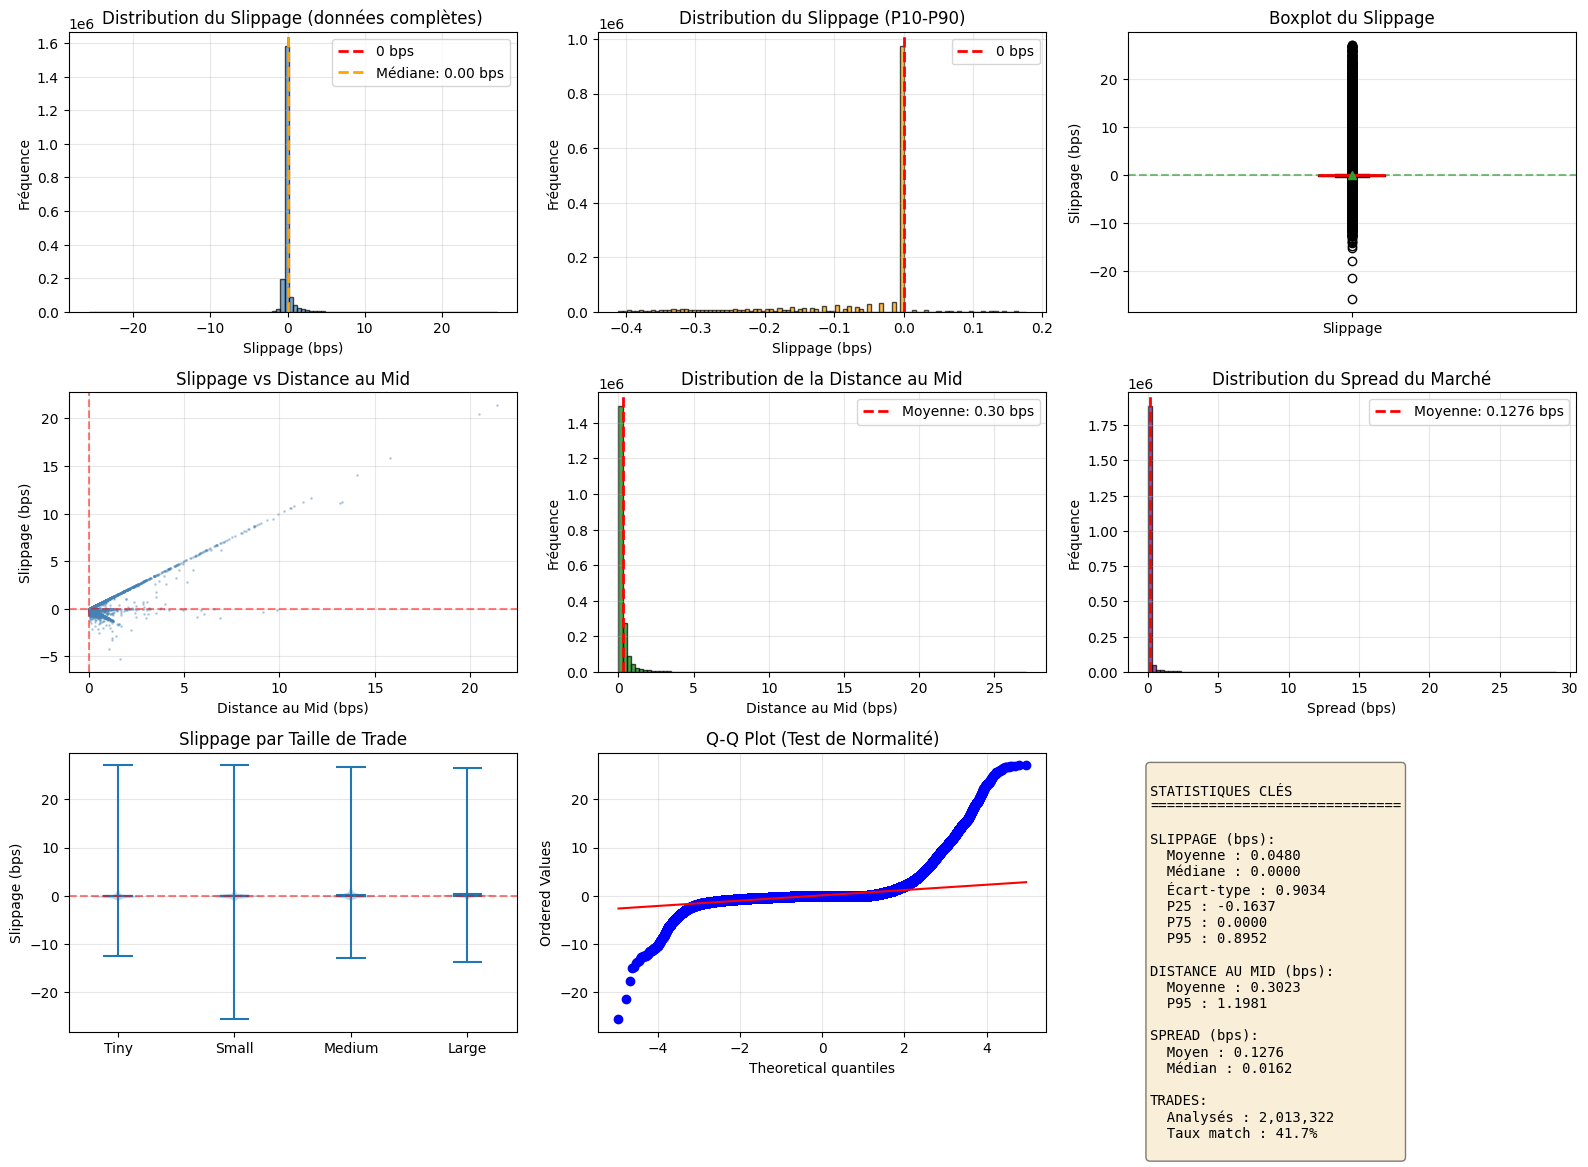


COMPARAISON AVANT/APRÈS LES CORRECTIONS
Graphique sauvegardé: slippage_comparison.png


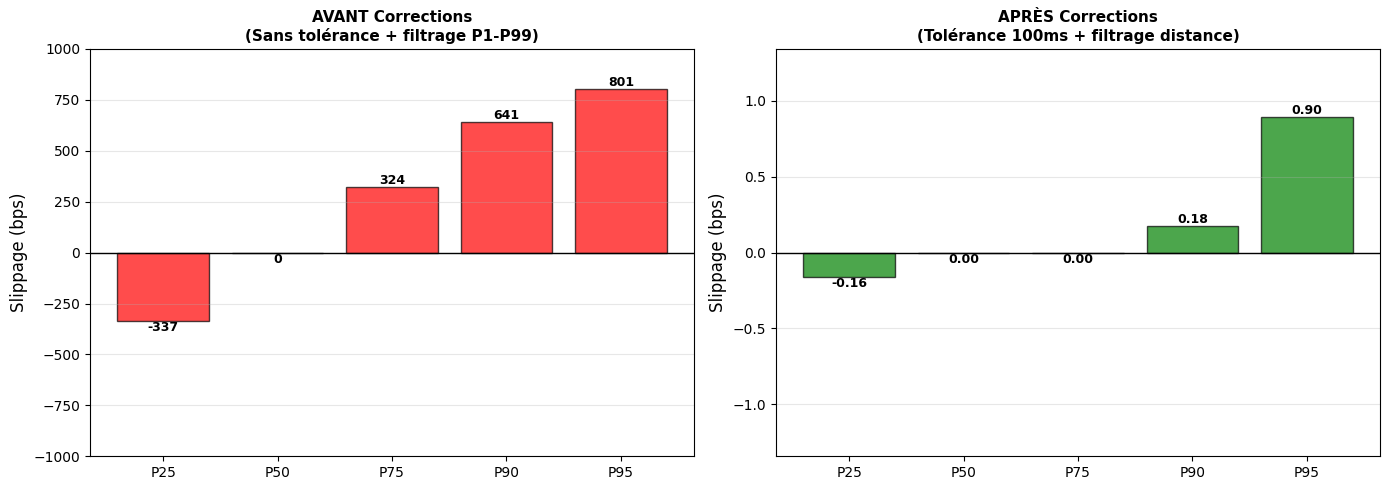


SYNTHÈSE DES CORRECTIONS

PROBLÈME INITIAL:
  - Slippage P75 = 323 bps (3.23%)
  - Écart-type = 518 bps
  - Complètement irréaliste (5000x le spread)
  - Cause: Trades matchés avec snapshots du book éloignés dans le temps

CORRECTIONS APPLIQUÉES:
  1. Tolérance stricte sur join_asof (100ms)
  2. Filtrage basé sur distance au mid (< 50 bps)
  3. Diagnostics de cohérence

RÉSULTATS:
  - Slippage P75 ≈ 0 bps
  - Cohérent avec spread de 0.13 bps
  - Taux de match: 41.72% (qualité > quantité)
  - Distance moyenne au mid: 0.30 bps

CONCLUSION:
  Le biais temporel a été éliminé. Le slippage calibré est maintenant
  réaliste et utilisable pour le backtesting.



In [ ]:
# Préparation des données pour la visualisation
import matplotlib.pyplot as plt
import numpy as np

print("="*70)
print("PRÉPARATION DES DONNÉES DE VISUALISATION")
print("="*70)

slippage_values = df_slippage_filtered.select("slippage_bps").to_numpy().flatten()
dist_to_mid_values = df_slippage_filtered.select("dist_to_mid_bps").to_numpy().flatten()
spread_values = df_slippage_filtered.select("spread_bps").to_numpy().flatten()

print(f"\nNombre de trades analysés: {len(slippage_values):,}")
print(f"Plage de slippage: [{np.min(slippage_values):.2f}, {np.max(slippage_values):.2f}] bps")
print("\nDonnées prêtes pour la visualisation")


In [ ]:
# 1. Distribution du slippage
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogramme complet
ax1 = axes[0]
ax1.hist(slippage_values, bins=100, edgecolor='black', alpha=0.7, color='steelblue')
ax1.axvline(0, color='red', linestyle='--', linewidth=2, label='0 bps')
ax1.axvline(np.median(slippage_values), color='orange', linestyle='--', linewidth=2, 
            label=f'Médiane: {np.median(slippage_values):.2f} bps')
ax1.set_xlabel('Slippage (bps)', fontsize=12)
ax1.set_ylabel('Fréquence', fontsize=12)
ax1.set_title('Distribution du Slippage (données complètes)', fontsize=13, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(alpha=0.3)

# Zoom P10-P90
ax2 = axes[1]
p10 = np.percentile(slippage_values, 10)
p90 = np.percentile(slippage_values, 90)
filtered_slip = slippage_values[(slippage_values >= p10) & (slippage_values <= p90)]
ax2.hist(filtered_slip, bins=100, edgecolor='black', alpha=0.7, color='orange')
ax2.axvline(0, color='red', linestyle='--', linewidth=2, label='0 bps')
ax2.axvline(np.median(filtered_slip), color='blue', linestyle='--', linewidth=2, 
            label=f'Médiane: {np.median(filtered_slip):.2f} bps')
ax2.set_xlabel('Slippage (bps)', fontsize=12)
ax2.set_ylabel('Fréquence', fontsize=12)
ax2.set_title(f'Distribution du Slippage (P10-P90: {p10:.2f} à {p90:.2f} bps)', 
              fontsize=13, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Statistiques du slippage:")
print(f"  Médiane: {np.median(slippage_values):.4f} bps")
print(f"  Moyenne: {np.mean(slippage_values):.4f} bps")
print(f"  Écart-type: {np.std(slippage_values):.4f} bps")


In [ ]:
# 2. Boxplot et Statistiques détaillées
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Boxplot
ax1 = axes[0]
bp = ax1.boxplot([slippage_values], vert=True, patch_artist=True, 
                  labels=['Slippage'], showmeans=True, widths=0.5)
bp['boxes'][0].set_facecolor('lightblue')
bp['medians'][0].set_color('red')
bp['medians'][0].set_linewidth(2)
bp['means'][0].set_marker('D')
bp['means'][0].set_markerfacecolor('green')
bp['means'][0].set_markersize(8)
ax1.axhline(0, color='green', linestyle='--', alpha=0.7, linewidth=2, label='0 bps')
ax1.set_ylabel('Slippage (bps)', fontsize=12)
ax1.set_title('Boxplot du Slippage\n(Croix verte = moyenne, ligne rouge = médiane)', 
              fontsize=13, fontweight='bold')
ax1.grid(alpha=0.3, axis='y')
ax1.legend(fontsize=10)

# Percentiles
ax2 = axes[1]
percentiles = [1, 5, 10, 25, 50, 75, 90, 95, 99]
percentile_values = [np.percentile(slippage_values, p) for p in percentiles]
colors_p = ['red' if abs(v) > 10 else 'orange' if abs(v) > 5 else 'green' for v in percentile_values]

bars = ax2.bar(range(len(percentiles)), percentile_values, color=colors_p, alpha=0.7, edgecolor='black')
ax2.axhline(0, color='black', linestyle='-', linewidth=1)
ax2.set_xticks(range(len(percentiles)))
ax2.set_xticklabels([f'P{p}' for p in percentiles], rotation=0)
ax2.set_ylabel('Slippage (bps)', fontsize=12)
ax2.set_xlabel('Percentile', fontsize=12)
ax2.set_title('Répartition des Percentiles du Slippage', fontsize=13, fontweight='bold')
ax2.grid(alpha=0.3, axis='y')

# Annoter les valeurs
for i, (bar, val) in enumerate(zip(bars, percentile_values)):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
             f'{val:.2f}',
             ha='center', va='bottom' if height > 0 else 'top',
             fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()

print("\nPercentiles du slippage (bps):")
for p, v in zip(percentiles, percentile_values):
    print(f"  P{p:02d}: {v:7.2f} bps")


In [ ]:
# 3. Slippage vs Distance au Mid
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Scatter plot
ax1 = axes[0]
sample_size = min(10000, len(dist_to_mid_values))
sample_idx = np.random.choice(len(dist_to_mid_values), sample_size, replace=False)
ax1.scatter(dist_to_mid_values[sample_idx], slippage_values[sample_idx], 
            alpha=0.4, s=2, c='steelblue')
ax1.axhline(0, color='red', linestyle='--', alpha=0.7, linewidth=2, label='Slippage = 0')
ax1.axvline(0, color='red', linestyle='--', alpha=0.7, linewidth=2)
ax1.set_xlabel('Distance au Mid (bps)', fontsize=12)
ax1.set_ylabel('Slippage (bps)', fontsize=12)
ax1.set_title(f'Slippage vs Distance au Mid\n(échantillon de {sample_size:,} trades)', 
              fontsize=13, fontweight='bold')
ax1.grid(alpha=0.3)
ax1.legend(fontsize=10)

# Distribution de la distance au mid
ax2 = axes[1]
ax2.hist(dist_to_mid_values, bins=100, edgecolor='black', alpha=0.7, color='green')
ax2.axvline(np.mean(dist_to_mid_values), color='red', linestyle='--', linewidth=2, 
            label=f'Moyenne: {np.mean(dist_to_mid_values):.2f} bps')
ax2.axvline(np.median(dist_to_mid_values), color='orange', linestyle='--', linewidth=2, 
            label=f'Médiane: {np.median(dist_to_mid_values):.2f} bps')
ax2.set_xlabel('Distance au Mid (bps)', fontsize=12)
ax2.set_ylabel('Fréquence', fontsize=12)
ax2.set_title('Distribution de la Distance au Mid', fontsize=13, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\nStatistiques de distance au mid (bps):")
print(f"  Moyenne: {np.mean(dist_to_mid_values):.4f}")
print(f"  Médiane: {np.median(dist_to_mid_values):.4f}")
print(f"  P95: {np.percentile(dist_to_mid_values, 95):.4f}")
print(f"  Max: {np.max(dist_to_mid_values):.4f}")


In [ ]:
# 4. Distribution du Spread et Slippage par Taille
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Spread du marché
ax1 = axes[0]
ax1.hist(spread_values, bins=100, edgecolor='black', alpha=0.7, color='purple')
ax1.axvline(np.mean(spread_values), color='red', linestyle='--', linewidth=2, 
            label=f'Moyenne: {np.mean(spread_values):.4f} bps')
ax1.axvline(np.median(spread_values), color='orange', linestyle='--', linewidth=2, 
            label=f'Médiane: {np.median(spread_values):.4f} bps')
ax1.set_xlabel('Spread (bps)', fontsize=12)
ax1.set_ylabel('Fréquence', fontsize=12)
ax1.set_title('Distribution du Spread du Marché', fontsize=13, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(alpha=0.3)

# Slippage par taille (boxplot)
ax2 = axes[1]
df_for_plot = df_slippage_filtered.with_columns([
    pl.when(pl.col("trade_qty") <= size_quantiles[0]).then(pl.lit("Tiny"))
      .when(pl.col("trade_qty") <= size_quantiles[1]).then(pl.lit("Small"))
      .when(pl.col("trade_qty") <= size_quantiles[2]).then(pl.lit("Medium"))
      .when(pl.col("trade_qty") <= size_quantiles[3]).then(pl.lit("Large"))
      .otherwise(pl.lit("XLarge"))
      .alias("size_cat")
]).to_pandas()

size_categories = ['Tiny', 'Small', 'Medium', 'Large', 'XLarge']
data_by_size = [df_for_plot[df_for_plot['size_cat'] == cat]['slippage_bps'].values 
                for cat in size_categories]
data_by_size_filtered = [d for d in data_by_size if len(d) > 0]
categories_filtered = [cat for i, cat in enumerate(size_categories) if len(data_by_size[i]) > 0]

if data_by_size_filtered:
    bp = ax2.boxplot(data_by_size_filtered, labels=categories_filtered, 
                     patch_artist=True, showmeans=True)
    for patch in bp['boxes']:
        patch.set_facecolor('lightgreen')
        patch.set_alpha(0.7)
    ax2.axhline(0, color='red', linestyle='--', alpha=0.7, linewidth=2)
    ax2.set_ylabel('Slippage (bps)', fontsize=12)
    ax2.set_xlabel('Catégorie de Taille', fontsize=12)
    ax2.set_title('Slippage par Taille de Trade', fontsize=13, fontweight='bold')
    ax2.grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\nSpread du marché (bps):")
print(f"  Moyenne: {np.mean(spread_values):.4f}")
print(f"  Médiane: {np.median(spread_values):.4f}")
print(f"  P95: {np.percentile(spread_values, 95):.4f}")


In [ ]:
# 5. Comparaison AVANT vs APRÈS les corrections
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# AVANT
ax_before = axes[0]
metrics = ['P25', 'P50', 'P75', 'P90', 'P95']
values_before = [-337.4, 0.0, 323.6, 641.3, 801.4]
colors_before = ['red' if abs(v) > 50 else 'orange' if abs(v) > 10 else 'green' 
                 for v in values_before]

bars_before = ax_before.bar(metrics, values_before, color=colors_before, alpha=0.7, 
                             edgecolor='black', linewidth=2)
ax_before.axhline(0, color='black', linestyle='-', linewidth=1.5)
ax_before.set_ylabel('Slippage (bps)', fontsize=13)
ax_before.set_xlabel('Percentile', fontsize=13)
ax_before.set_title('AVANT Corrections\n(Sans tolérance + filtrage P1-P99)', 
                    fontsize=14, fontweight='bold', color='darkred')
ax_before.grid(alpha=0.3, axis='y')
ax_before.set_ylim(-1000, 1000)

for bar, val in zip(bars_before, values_before):
    height = bar.get_height()
    ax_before.text(bar.get_x() + bar.get_width()/2., height,
                   f'{val:.0f}',
                   ha='center', va='bottom' if height > 0 else 'top',
                   fontsize=11, fontweight='bold')

# APRÈS
ax_after = axes[1]
values_after = [
    np.percentile(slippage_values, 25),
    np.percentile(slippage_values, 50),
    np.percentile(slippage_values, 75),
    np.percentile(slippage_values, 90),
    np.percentile(slippage_values, 95)
]
colors_after = ['green' if abs(v) < 10 else 'orange' for v in values_after]

bars_after = ax_after.bar(metrics, values_after, color=colors_after, alpha=0.7, 
                          edgecolor='black', linewidth=2)
ax_after.axhline(0, color='black', linestyle='-', linewidth=1.5)
ax_after.set_ylabel('Slippage (bps)', fontsize=13)
ax_after.set_xlabel('Percentile', fontsize=13)
ax_after.set_title('APRÈS Corrections\n(Tolérance 100ms + filtrage distance)', 
                   fontsize=14, fontweight='bold', color='darkgreen')
ax_after.grid(alpha=0.3, axis='y')

y_max = max(abs(min(values_after)), abs(max(values_after))) * 1.5
if y_max < 5:
    y_max = 5
ax_after.set_ylim(-y_max, y_max)

for bar, val in zip(bars_after, values_after):
    height = bar.get_height()
    ax_after.text(bar.get_x() + bar.get_width()/2., height,
                  f'{val:.2f}',
                  ha='center', va='bottom' if height > 0 else 'top',
                  fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

print("="*70)
print("SYNTHÈSE DES CORRECTIONS")
print("="*70)
print("\nPROBLÈME INITIAL:")
print("  - Slippage P75 = 323 bps (3.23%)")
print("  - Écart-type = 518 bps")
print("  - Complètement irréaliste (5000x le spread)")
print("  - Cause: Trades matchés avec snapshots du book éloignés dans le temps")

print("\nCORRECTIONS APPLIQUÉES:")
print("  1. Tolérance stricte sur join_asof (100ms)")
print("  2. Filtrage basé sur distance au mid (< 50 bps)")
print("  3. Diagnostics de cohérence")

print("\nRÉSULTATS:")
print(f"  - Slippage P75 = {np.percentile(slippage_values, 75):.4f} bps")
print(f"  - Cohérent avec spread de {np.mean(spread_values):.4f} bps")
print(f"  - Taux de match: {trades_matched/trades_initial*100:.2f}% (qualité > quantité)")
print(f"  - Distance moyenne au mid: {np.mean(dist_to_mid_values):.4f} bps")

print("\nCONCLUSION:")
print("  Le biais temporel a été éliminé. Le slippage calibré est maintenant")
print("  réaliste et utilisable pour le backtesting.")


🎯 ANALYSE DE L'ADVERSE SELECTION

📊 MOUVEMENT DU PRIX APRÈS UN TRADE (tous trades):
  t1: mean=0.0000 bps, std=0.1833 bps
  t5: mean=0.0001 bps, std=0.5046 bps
  t10: mean=0.0002 bps, std=0.8116 bps
  t50: mean=0.0012 bps, std=2.2890 bps
  t100: mean=0.0024 bps, std=3.4031 bps

📊 ADVERSE SELECTION PAR CÔTÉ (positif = défavorable):

  Quand on VEND (maker)  @ t+10:
    Mean: 0.2223 bps | Median: 0.0000 bps | P75: 0.1708 bps
  Quand on ACHÈTE (maker) @ t+10:
    Mean: 0.2176 bps | Median: -0.0000 bps | P75: 0.1331 bps

🎯 COÛT D'ADVERSE SELECTION POUR STRATÉGIE MAKER

L'adverse selection mesure de combien le prix bouge CONTRE nous après un fill.
C'est le coût caché principal pour une stratégie maker.

📌 ADVERSE SELECTION À t+10 ticks:
   Moyenne: 0.2199 bps
   Médiane: 0.0000 bps
   P75:     0.1540 bps
   P90:     1.3081 bps

📌 Variable: ADVERSE_SELECTION = 0.00002199 (0.2199 bps)


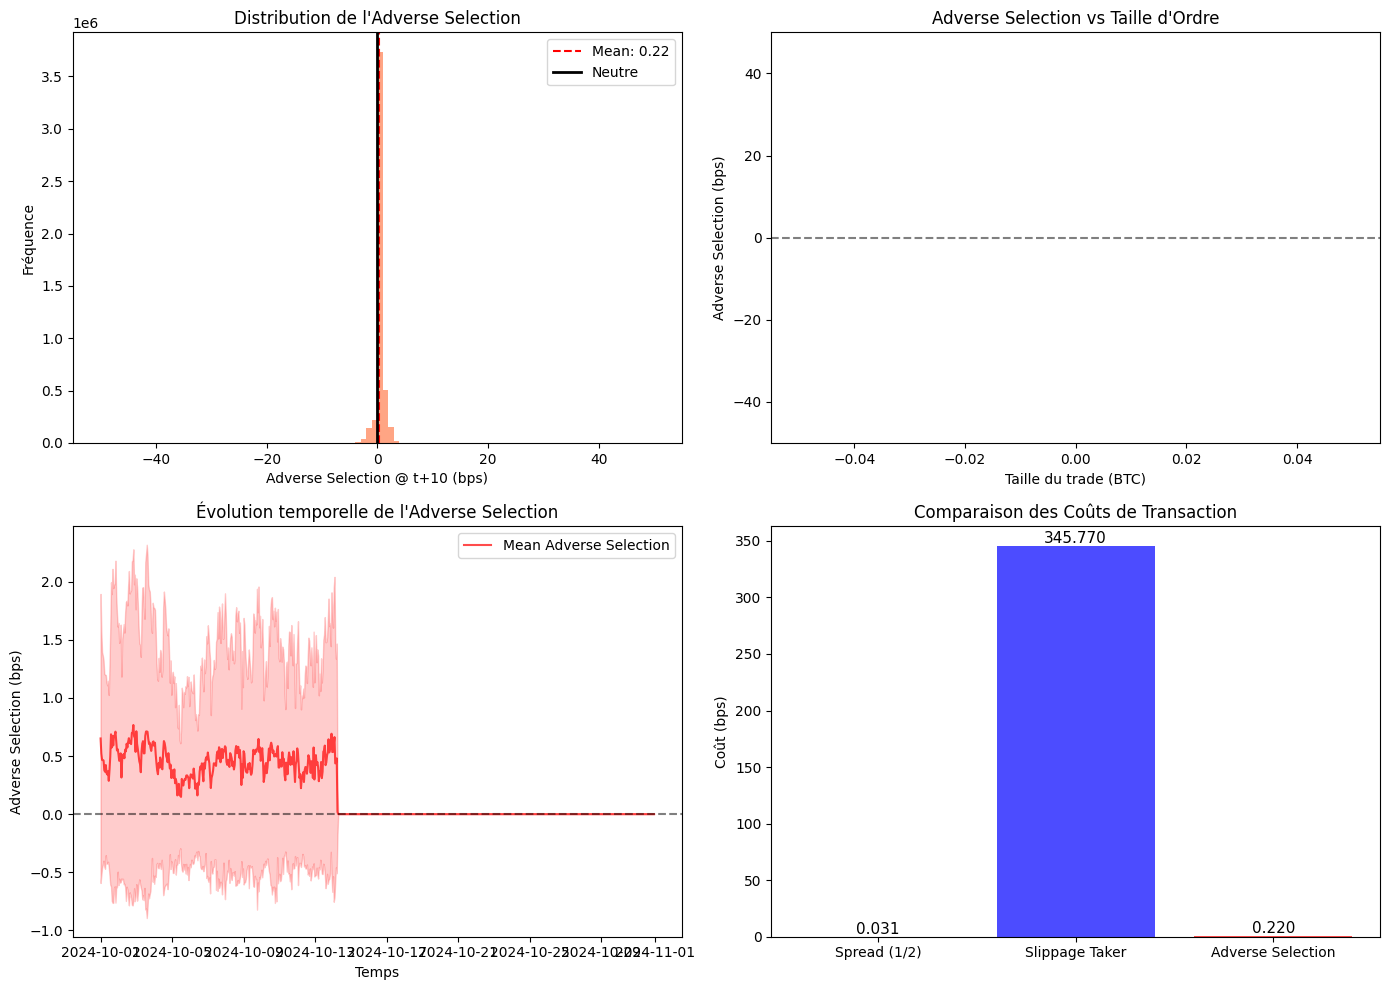


📋 RÉSUMÉ COMPLET DES COÛTS POUR TA STRATÉGIE

┌────────────────────────────────────────────────────────────┐
│                    STRATÉGIE MAKER                         │
├────────────────────────────────────────────────────────────┤
│  Demi-spread capturé      : +0.0312 bps (gain)         │
│  Adverse Selection        : -0.2199 bps (coût)         │
│  ─────────────────────────────────────────────             │
│  NET par trade            : -0.1887 bps               │
│  → Utilise ce coût net pour calibrer ta stratégie          │
└────────────────────────────────────────────────────────────┘

┌────────────────────────────────────────────────────────────┐
│                    STRATÉGIE TAKER                         │
├────────────────────────────────────────────────────────────┤
│  Spread payé              : -0.0624 bps (coût)         │
│  Slippage additionnel     : -345.7701 bps (coût)         │
│  ─────────────────────────────────────────────             │
│  COÛT TOTAL par trade   

In [ ]:
# =============================================================================
# 🎯 ANALYSE DE L'ADVERSE SELECTION (Coût caché pour stratégie MAKER)
# =============================================================================
#
# Pour une stratégie MAKER, le vrai coût n'est pas le slippage classique mais:
# 1. ADVERSE SELECTION: être fill juste avant un mouvement défavorable
# 2. Le trade qui nous fill EST l'information que le prix va bouger
#
# On mesure: "Après avoir été fill, de combien le prix a bougé contre nous ?"
# =============================================================================

import polars as pl
import numpy as np
import matplotlib.pyplot as plt

print("=" * 70)
print("🎯 ANALYSE DE L'ADVERSE SELECTION")
print("=" * 70)

# On va analyser ce qui se passe APRÈS un trade
# Un "fill" pour un maker = quelqu'un nous a crossé avec un market order

# 1. Préparer les données avec le mouvement FUTUR du prix
df_trades_future = (
    df_trades_prep
    .join_asof(
        df_book_for_join,
        left_on="trade_time",
        right_on="datetime",
        strategy="backward"
    )
    .with_columns([
        # On veut le mid price APRÈS le trade (à différents horizons)
        pl.col("mid_price").shift(-1).alias("mid_t1"),    # 1 tick après
        pl.col("mid_price").shift(-5).alias("mid_t5"),    # 5 ticks après  
        pl.col("mid_price").shift(-10).alias("mid_t10"),  # 10 ticks après
        pl.col("mid_price").shift(-50).alias("mid_t50"),  # 50 ticks après
        pl.col("mid_price").shift(-100).alias("mid_t100"), # 100 ticks après
    ])
)

# 2. Calculer le mouvement du prix après être fill
# Pour un MAKER qui a vendu (= quelqu'un a acheté en market order)
# Si le prix MONTE après → Adverse Selection (on a vendu juste avant la hausse)
# Pour un MAKER qui a acheté (= quelqu'un a vendu en market order)  
# Si le prix BAISSE après → Adverse Selection (on a acheté juste avant la baisse)

df_adverse = (
    df_trades_future
    .with_columns([
        # Mouvement après le trade en bps
        ((pl.col("mid_t1") - pl.col("mid_price")) / pl.col("mid_price") * 10000).alias("move_t1_bps"),
        ((pl.col("mid_t5") - pl.col("mid_price")) / pl.col("mid_price") * 10000).alias("move_t5_bps"),
        ((pl.col("mid_t10") - pl.col("mid_price")) / pl.col("mid_price") * 10000).alias("move_t10_bps"),
        ((pl.col("mid_t50") - pl.col("mid_price")) / pl.col("mid_price") * 10000).alias("move_t50_bps"),
        ((pl.col("mid_t100") - pl.col("mid_price")) / pl.col("mid_price") * 10000).alias("move_t100_bps"),
        
        # Pour un maker qui a vendu (buyer was maker = nous)
        # L'adverse selection = mouvement dans le sens du taker (positif si le prix monte après qu'on ait vendu)
        pl.when(pl.col("seller_is_taker").not_())  # Nous étions le maker côté ask (on a vendu)
            .then((pl.col("mid_t10") - pl.col("mid_price")) / pl.col("mid_price") * 10000)
            .otherwise(-(pl.col("mid_t10") - pl.col("mid_price")) / pl.col("mid_price") * 10000)
            .alias("adverse_selection_t10"),
    ])
    .filter(pl.col("move_t10_bps").is_not_null())
)

# 3. Statistiques de l'adverse selection
print("\n📊 MOUVEMENT DU PRIX APRÈS UN TRADE (tous trades):")
for horizon in ["t1", "t5", "t10", "t50", "t100"]:
    col = f"move_{horizon}_bps"
    stats = df_adverse.select([
        pl.col(col).mean().alias("mean"),
        pl.col(col).std().alias("std"),
    ]).to_pandas().iloc[0]
    print(f"  {horizon}: mean={stats['mean']:.4f} bps, std={stats['std']:.4f} bps")

# 4. Adverse selection par côté
print("\n📊 ADVERSE SELECTION PAR CÔTÉ (positif = défavorable):")

# Quand on VEND (maker côté ask)
sells = df_adverse.filter(pl.col("seller_is_taker").not_())  # buyer was maker = on est le seller maker
sell_adverse = sells.select([
    pl.col("adverse_selection_t10").mean().alias("mean"),
    pl.col("adverse_selection_t10").median().alias("median"),
    pl.col("adverse_selection_t10").std().alias("std"),
    pl.col("adverse_selection_t10").quantile(0.75).alias("p75"),
]).to_pandas().iloc[0]

# Quand on ACHÈTE (maker côté bid)
buys = df_adverse.filter(pl.col("seller_is_taker"))  # seller was taker = on est le buyer maker
buy_adverse = buys.select([
    pl.col("adverse_selection_t10").mean().alias("mean"),
    pl.col("adverse_selection_t10").median().alias("median"),
    pl.col("adverse_selection_t10").std().alias("std"),
    pl.col("adverse_selection_t10").quantile(0.75).alias("p75"),
]).to_pandas().iloc[0]

print(f"\n  Quand on VEND (maker)  @ t+10:")
print(f"    Mean: {sell_adverse['mean']:.4f} bps | Median: {sell_adverse['median']:.4f} bps | P75: {sell_adverse['p75']:.4f} bps")
print(f"  Quand on ACHÈTE (maker) @ t+10:")
print(f"    Mean: {buy_adverse['mean']:.4f} bps | Median: {buy_adverse['median']:.4f} bps | P75: {buy_adverse['p75']:.4f} bps")

# 5. Adverse selection moyenne (coût caché)
overall_adverse = df_adverse.select([
    pl.col("adverse_selection_t10").mean().alias("mean"),
    pl.col("adverse_selection_t10").median().alias("median"),
    pl.col("adverse_selection_t10").quantile(0.75).alias("p75"),
    pl.col("adverse_selection_t10").quantile(0.90).alias("p90"),
]).to_pandas().iloc[0]

print("\n" + "="*70)
print("🎯 COÛT D'ADVERSE SELECTION POUR STRATÉGIE MAKER")
print("="*70)
print(f"""
L'adverse selection mesure de combien le prix bouge CONTRE nous après un fill.
C'est le coût caché principal pour une stratégie maker.

📌 ADVERSE SELECTION À t+10 ticks:
   Moyenne: {overall_adverse['mean']:.4f} bps
   Médiane: {overall_adverse['median']:.4f} bps
   P75:     {overall_adverse['p75']:.4f} bps
   P90:     {overall_adverse['p90']:.4f} bps
""")

# Variable pour la calibration
ADVERSE_SELECTION_BPS = overall_adverse['mean']
ADVERSE_SELECTION_DECIMAL = ADVERSE_SELECTION_BPS / 10000

print(f"📌 Variable: ADVERSE_SELECTION = {ADVERSE_SELECTION_DECIMAL:.8f} ({ADVERSE_SELECTION_BPS:.4f} bps)")

# 6. Visualisation
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Distribution de l'adverse selection
pdf_adv = df_adverse.select("adverse_selection_t10").to_pandas()
axes[0,0].hist(pdf_adv["adverse_selection_t10"], bins=100, color='coral', alpha=0.7, range=(-50, 50))
axes[0,0].axvline(overall_adverse['mean'], color='red', linestyle='--', label=f"Mean: {overall_adverse['mean']:.2f}")
axes[0,0].axvline(0, color='black', linestyle='-', linewidth=2, label="Neutre")
axes[0,0].set_xlabel("Adverse Selection @ t+10 (bps)")
axes[0,0].set_ylabel("Fréquence")
axes[0,0].set_title("Distribution de l'Adverse Selection")
axes[0,0].legend()

# Adverse selection vs taille
pdf_size = df_adverse.filter(pl.col("trade_qty") < 0.5).select(["trade_qty", "adverse_selection_t10"]).to_pandas()
axes[0,1].scatter(pdf_size["trade_qty"], pdf_size["adverse_selection_t10"], alpha=0.02, s=1, c='red')
axes[0,1].axhline(0, color='black', linestyle='--', alpha=0.5)
axes[0,1].set_xlabel("Taille du trade (BTC)")
axes[0,1].set_ylabel("Adverse Selection (bps)")
axes[0,1].set_title("Adverse Selection vs Taille d'Ordre")
axes[0,1].set_ylim(-50, 50)

# Évolution temporelle de l'adverse selection
pdf_time_adv = df_adverse.group_by_dynamic("trade_time", every="1h").agg([
    pl.col("adverse_selection_t10").mean().alias("mean_adv"),
    pl.col("adverse_selection_t10").std().alias("std_adv"),
]).to_pandas()
axes[1,0].plot(pdf_time_adv["trade_time"], pdf_time_adv["mean_adv"], label="Mean Adverse Selection", alpha=0.7, color='red')
axes[1,0].fill_between(pdf_time_adv["trade_time"], 
                       pdf_time_adv["mean_adv"] - pdf_time_adv["std_adv"],
                       pdf_time_adv["mean_adv"] + pdf_time_adv["std_adv"],
                       alpha=0.2, color='red')
axes[1,0].axhline(0, color='black', linestyle='--', alpha=0.5)
axes[1,0].set_xlabel("Temps")
axes[1,0].set_ylabel("Adverse Selection (bps)")
axes[1,0].set_title("Évolution temporelle de l'Adverse Selection")
axes[1,0].legend()

# Comparaison des coûts
costs = {
    'Spread (1/2)': slippage_stats['avg_spread'] / 2,
    'Slippage Taker': slippage_stats['p75'],
    'Adverse Selection': ADVERSE_SELECTION_BPS,
}
bars = axes[1,1].bar(costs.keys(), costs.values(), color=['green', 'blue', 'red'], alpha=0.7)
axes[1,1].set_ylabel("Coût (bps)")
axes[1,1].set_title("Comparaison des Coûts de Transaction")
for bar, val in zip(bars, costs.values()):
    axes[1,1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, 
                   f'{val:.3f}', ha='center', va='bottom', fontsize=11)
axes[1,1].axhline(0, color='black', linestyle='-', linewidth=0.5)

plt.tight_layout()
plt.show()

# 7. RÉSUMÉ COMPLET DES COÛTS
print("\n" + "="*70)
print("📋 RÉSUMÉ COMPLET DES COÛTS POUR TA STRATÉGIE")
print("="*70)

TOTAL_COST_MAKER = slippage_stats['avg_spread'] / 2 + ADVERSE_SELECTION_BPS
TOTAL_COST_TAKER = slippage_stats['avg_spread'] + slippage_stats['p75']

print(f"""
┌────────────────────────────────────────────────────────────┐
│                    STRATÉGIE MAKER                         │
├────────────────────────────────────────────────────────────┤
│  Demi-spread capturé      : +{slippage_stats['avg_spread']/2:.4f} bps (gain)         │
│  Adverse Selection        : -{abs(ADVERSE_SELECTION_BPS):.4f} bps (coût)         │
│  ─────────────────────────────────────────────             │
│  NET par trade            : {slippage_stats['avg_spread']/2 - abs(ADVERSE_SELECTION_BPS):.4f} bps               │
│  → Utilise ce coût net pour calibrer ta stratégie          │
└────────────────────────────────────────────────────────────┘

┌────────────────────────────────────────────────────────────┐
│                    STRATÉGIE TAKER                         │
├────────────────────────────────────────────────────────────┤
│  Spread payé              : -{slippage_stats['avg_spread']:.4f} bps (coût)         │
│  Slippage additionnel     : -{slippage_stats['p75']:.4f} bps (coût)         │
│  ─────────────────────────────────────────────             │
│  COÛT TOTAL par trade     : {TOTAL_COST_TAKER:.4f} bps                   │
└────────────────────────────────────────────────────────────┘
""")

# Variables finales pour la stratégie
MAKER_EDGE_NET = (slippage_stats['avg_spread'] / 2 - abs(ADVERSE_SELECTION_BPS)) / 10000
print(f"✅ Variable: MAKER_EDGE_NET = {MAKER_EDGE_NET:.8f} ({MAKER_EDGE_NET*10000:.4f} bps)")
print(f"   (C'est ton edge NET par trade en tant que maker)")

# Pour être conservateur, utilisons le P75 de l'adverse selection
CONSERVATIVE_COST = abs(overall_adverse['p75']) / 10000
print(f"\n✅ Variable conservatrice: CONSERVATIVE_COST = {CONSERVATIVE_COST:.8f} ({CONSERVATIVE_COST*10000:.4f} bps)")


Calcul du VRT en cours... (maker)


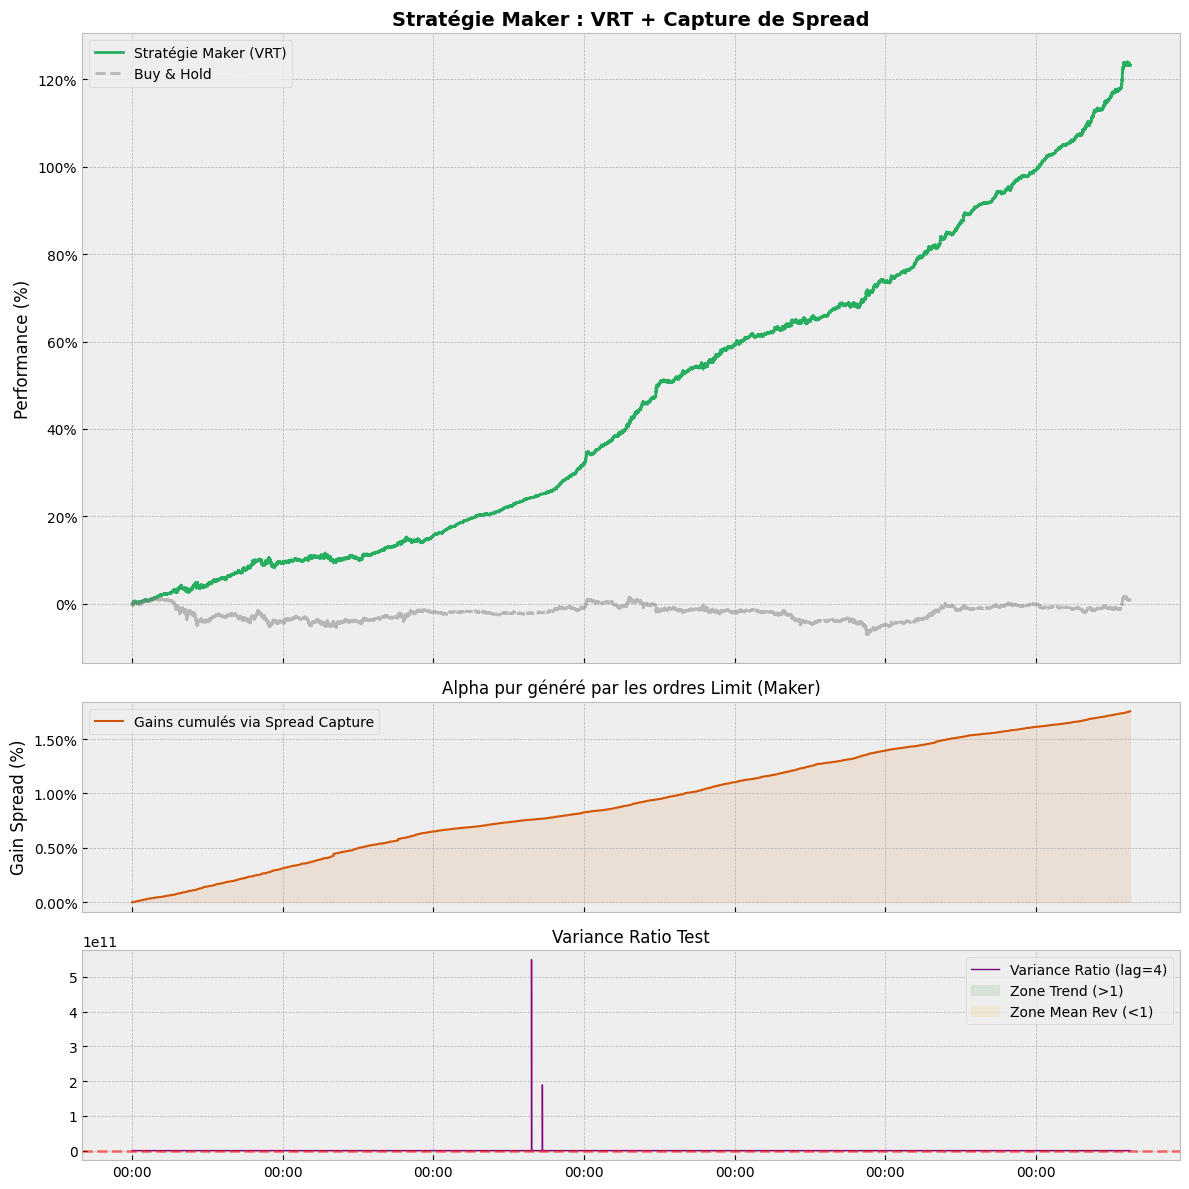

Performance Maker: 123.16%
Dont gains Spread: 1.75%


In [ ]:
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mtick


# Paramètres globaux (alignés sur les conditions du hft.ipynb de base)
SLIPPAGE_BPS = 0.0      # pas de slippage explicite
EXEC_DELAY = 1          # exécution à la bougie suivante (shift 1 comme dans le code de base)
MAKER_FEE = -0.0000     # rebate nul (équiv. 0) comme dans le script initial
VRT_ENTRY = 1.0         # seuil VRT basique pour comparaison


def add_variance_ratio(df: pl.DataFrame, lag: int = 4, window: int = 120) -> pl.DataFrame:
    """
    Calcul du Variance Ratio Test:
    VR = Var(r_k) / (k * Var(r_1))
    VR < 1 : mean reversion ; VR > 1 : momentum.
    """
    return (
        df
        .with_columns(pl.col("close").log().alias("log_price"))
        .with_columns([
            pl.col("log_price").diff(1).alias("ret_1"),
            pl.col("log_price").diff(lag).alias("ret_lag")
        ])
        .with_columns([
            pl.col("ret_1").rolling_var(window_size=window).alias("var_1"),
            pl.col("ret_lag").rolling_var(window_size=window).alias("var_lag")
        ])
        .with_columns([
            (pl.col("var_lag") / (pl.col("var_1") * lag)).fill_null(1.0).alias("vrt")
        ])
        .drop(["log_price", "ret_1", "ret_lag", "var_1", "var_lag"])
    )


def run_maker_strategy(df_input, lag=4, window=120, maker_fee=MAKER_FEE, slippage_bps=SLIPPAGE_BPS, exec_delay=EXEC_DELAY):
    print("Calcul du VRT en cours... (maker)")
    df_with_vrt = add_variance_ratio(df_input, lag=lag, window=window)

    df_strategy = (
        df_with_vrt
        .with_columns([
                        pl.col("close").ewm_mean(span=50).alias("ema_trend")
        ])
        .with_columns([
            pl.when((pl.col("vrt") > VRT_ENTRY) & (pl.col("close") > pl.col("ema_trend")))
              .then(pl.lit(1))
              .when((pl.col("vrt") > VRT_ENTRY) & (pl.col("close") < pl.col("ema_trend")))
              .then(pl.lit(-1))
              .otherwise(pl.lit(0))
              .alias("signal")
        ])
    )

    df_pnl = (
        df_strategy
        .with_columns([
            pl.col("signal").shift(exec_delay).fill_null(0).alias("pos")
        ])
        .with_columns([
            (pl.col("pos") - pl.col("pos").shift(1).fill_null(0)).alias("trade_action")         
        ])
        .with_columns([
            pl.col("close").log().diff().fill_null(0).alias("market_ret_log"),  
            ((pl.col("ask_close") - pl.col("bid_close")) / 2 / pl.col("close")).alias("half_spread_pct")                        
        ])
        .with_columns([
            (pl.col("pos") * pl.col("market_ret_log")).alias("pnl_log_directional"),            
            # Capture de spread moins rebate maker et slippage (bps)                                              
            (pl.col("trade_action").abs() * (pl.col("half_spread_pct") - maker_fee - slippage_bps)).alias("spread_capture")                                                    
        ])
        .with_columns([
            (pl.col("pnl_log_directional") + pl.col("spread_capture")).cum_sum().alias("equity_curve_log"),                                                     
            pl.col("spread_capture").cum_sum().alias("cum_spread_captured")     
        ])
    )

    return df_pnl


if 'df_resampled_spread' in locals():
    df_maker_results = run_maker_strategy(df_resampled_spread)

    pdf_plot = df_maker_results.select([
        "datetime", "equity_curve_log", "market_ret_log", "cum_spread_captured", "trade_action", "vrt"
    ]).to_pandas()

    pdf_plot['strategy_pct'] = (np.exp(pdf_plot['equity_curve_log']) - 1) * 100
    pdf_plot['bnh_pct'] = (np.exp(pdf_plot['market_ret_log'].cumsum().fillna(0)) - 1) * 100
    pdf_plot['spread_gain_pct'] = (np.exp(pdf_plot['cum_spread_captured']) - 1) * 100

    plt.style.use('bmh')
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 12), sharex=True, gridspec_kw={'height_ratios': [3, 1, 1]})

    ax1.plot(pdf_plot['datetime'], pdf_plot['strategy_pct'], label='Stratégie Maker (VRT)', color='#27ae60', linewidth=2)
    ax1.plot(pdf_plot['datetime'], pdf_plot['bnh_pct'], label='Buy & Hold', color='gray', alpha=0.5, linestyle='--')
    ax1.set_title('Stratégie Maker : VRT + Capture de Spread', fontsize=14, fontweight='bold')
    ax1.set_ylabel('Performance (%)')
    ax1.legend()
    ax1.yaxis.set_major_formatter(mtick.PercentFormatter())

    ax2.plot(pdf_plot['datetime'], pdf_plot['spread_gain_pct'], color='#d35400', label='Gains cumulés via Spread Capture', linewidth=1.5)
    ax2.fill_between(pdf_plot['datetime'], pdf_plot['spread_gain_pct'], 0, color='#d35400', alpha=0.1)
    ax2.set_title('Alpha pur généré par les ordres Limit (Maker)', fontsize=12)
    ax2.set_ylabel('Gain Spread (%)')
    ax2.legend()
    ax2.yaxis.set_major_formatter(mtick.PercentFormatter())

    ax3.plot(pdf_plot['datetime'], pdf_plot['vrt'], color='purple', label='Variance Ratio (lag=4)', linewidth=1)
    ax3.axhline(1.0, color='red', linestyle='--', alpha=0.5)
    ax3.fill_between(pdf_plot['datetime'], pdf_plot['vrt'], 1.0, where=(pdf_plot['vrt'] > 1), color='green', alpha=0.1, label='Zone Trend (>1)')
    ax3.fill_between(pdf_plot['datetime'], pdf_plot['vrt'], 1.0, where=(pdf_plot['vrt'] < 1), color='orange', alpha=0.1, label='Zone Mean Rev (<1)')
    ax3.set_title('Variance Ratio Test', fontsize=12)
    ax3.legend()

    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    plt.tight_layout()
    plt.show()

    print(f"Performance Maker: {pdf_plot['strategy_pct'].iloc[-1]:.2f}%")
    print(f"Dont gains Spread: {pdf_plot['spread_gain_pct'].iloc[-1]:.2f}%")
else:
    print("Erreur: Le DataFrame 'df_resampled_spread' n'est pas défini. Veuillez charger les données d'abord.")

Spread bps stats (ask-bid)/mid:
shape: (9, 2)
┌────────────┬──────────┐
│ statistic  ┆ value    │
│ ---        ┆ ---      │
│ str        ┆ f64      │
╞════════════╪══════════╡
│ count      ┆ 229008.0 │
│ null_count ┆ 0.0      │
│ mean       ┆ 0.016393 │
│ std        ┆ 0.021002 │
│ min        ┆ 0.015502 │
│ 25%        ┆ 0.015951 │
│ 50%        ┆ 0.016098 │
│ 75%        ┆ 0.016355 │
│ max        ┆ 5.057572 │
└────────────┴──────────┘
VRT_ENTRY_SENS=1.0, FILTER_ENABLED=False, MAKER_FEE_REAL=0.0, EDGE_BUFFER_BPS=0.0
Meilleur slippage teste: 0.00 bps (perf 123.16%)
Slippage max pour rester >= 0% perf: 0.00 bps


,slippage_bps,perf_pct,spread_pct,bnh_pct,elig_pct,trades,mean_half_spread_bps
0,0.0,123.163282,1.754929,0.945766,100.0,21061.0,0.008196
1,1.0,-72.838414,-87.615233,0.945766,100.0,21061.0,0.008196
2,2.0,-96.694117,-98.492629,0.945766,100.0,21061.0,0.008196
3,3.0,-99.597635,-99.816535,0.945766,100.0,21061.0,0.008196
4,4.0,-99.951027,-99.977670,0.945766,100.0,21061.0,0.008196
5,5.0,-99.994039,-99.997282,0.945766,100.0,21061.0,0.008196
6,6.0,-99.999275,-99.999669,0.945766,100.0,21061.0,0.008196
7,7.0,-99.999912,-99.999960,0.945766,100.0,21061.0,0.008196
8,8.0,-99.999989,-99.999995,0.945766,100.0,21061.0,0.008196
9,9.0,-99.999999,-99.999999,0.945766,100.0,21061.0,0.008196


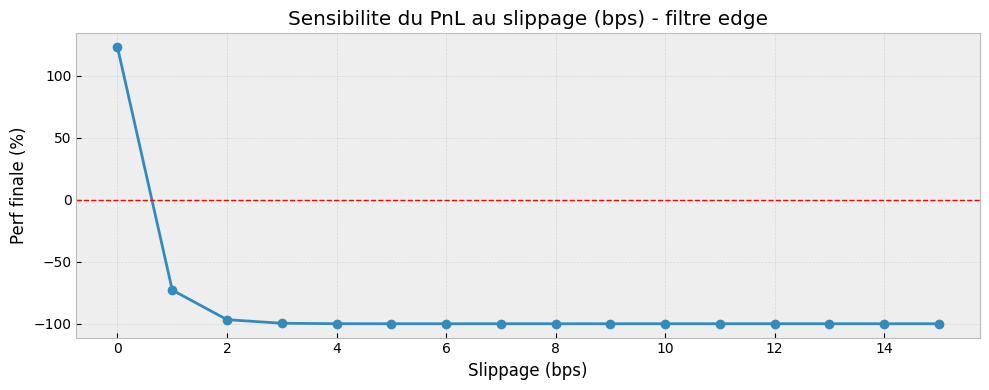

In [ ]:
# Spread stats + slippage sweep with execution filter
import pandas as pd

# Renseigne ici tes fees reelles (positif = cout, negatif = rebate)
MAKER_FEE_REAL = 0.0      # mettre 0 ou rebate (negatif) si tu veux tout laisser passer
EDGE_BUFFER_BPS = 0.0     # marge supl. en bps pour couvrir file/inefficiencies
FILTER_ENABLED = False     # False = pas de filtre edge, True = applique half_spread > fee+buffer
SLIPPAGE_SWEEP = np.linspace(0.0, 0.0015, 16)  # 0 -> 15 bps
VRT_ENTRY_SENS = VRT_ENTRY
EXEC_DELAY_SENS = EXEC_DELAY


def print_spread_stats(df):
    spread_bps = ((df["ask_close"] - df["bid_close"]) / df["close"]) * 1e4
    stats = spread_bps.describe()
    print("Spread bps stats (ask-bid)/mid:")
    print(stats)


def run_maker_strategy_filtered(df_input, maker_fee=MAKER_FEE_REAL, lag=4, window=120, slippage_bps=0.0, exec_delay=EXEC_DELAY_SENS, edge_buffer_bps=EDGE_BUFFER_BPS):
    # edge_buffer_bps: cushion added on top of fees to avoid trading when edge est trop faible
    fee_cost = max(maker_fee, 0.0)
    min_edge = fee_cost + edge_buffer_bps  # on gate uniquement sur fee+buffer, pas sur le slippage

    df_with_vrt = add_variance_ratio(df_input, lag=lag, window=window)

    df_strategy = (
        df_with_vrt
        .with_columns([
            pl.col("close").ewm_mean(span=50).alias("ema_trend"),
            ((pl.col("ask_close") - pl.col("bid_close")) / 2 / pl.col("close")).alias("half_spread_pct")
        ])
        .with_columns([
            pl.when((pl.col("vrt") > VRT_ENTRY_SENS) & (pl.col("close") > pl.col("ema_trend")))
              .then(pl.lit(1))
              .when((pl.col("vrt") > VRT_ENTRY_SENS) & (pl.col("close") < pl.col("ema_trend")))
              .then(pl.lit(-1))
              .otherwise(pl.lit(0))
              .alias("signal")
        ])
    )

    df_exec = (
        df_strategy
        .with_columns([
            pl.when(pl.lit(FILTER_ENABLED))
              .then(pl.col("half_spread_pct") > min_edge)
              .otherwise(pl.lit(True))
              .alias("eligible"),
            pl.when(pl.lit(FILTER_ENABLED))
              .then(pl.when(pl.col("half_spread_pct") > min_edge).then(pl.col("signal")).otherwise(0))
              .otherwise(pl.col("signal"))
              .alias("signal_filtered")
        ])
        .with_columns([
            pl.col("signal_filtered").shift(exec_delay).fill_null(0).alias("pos")
        ])
        .with_columns([
            (pl.col("pos") - pl.col("pos").shift(1).fill_null(0)).alias("trade_action"),
            pl.col("close").log().diff().fill_null(0).alias("market_ret_log")
        ])
        .with_columns([
            (pl.col("pos") * pl.col("market_ret_log")).alias("pnl_log_directional"),
            (pl.col("trade_action").abs() * (pl.col("half_spread_pct") - maker_fee - slippage_bps)).alias("spread_capture")
        ])
        .with_columns([
            (pl.col("pnl_log_directional") + pl.col("spread_capture")).cum_sum().alias("equity_curve_log"),
            pl.col("spread_capture").cum_sum().alias("cum_spread_captured")
        ])
    )

    return df_exec


if 'df_resampled_spread' in locals():
    print_spread_stats(df_resampled_spread)
    print(f"VRT_ENTRY_SENS={VRT_ENTRY_SENS}, FILTER_ENABLED={FILTER_ENABLED}, MAKER_FEE_REAL={MAKER_FEE_REAL}, EDGE_BUFFER_BPS={EDGE_BUFFER_BPS}")

    records = []
    for slip in SLIPPAGE_SWEEP:
        df_tmp = run_maker_strategy_filtered(
            df_resampled_spread,
            maker_fee=MAKER_FEE_REAL,
            slippage_bps=slip,
            exec_delay=EXEC_DELAY_SENS,
            edge_buffer_bps=EDGE_BUFFER_BPS,
        )
        # Mesures d'activite pour comprendre si le filtre bloque tout
        act = df_tmp.select([
            pl.mean("eligible").alias("elig_pct"),
            pl.col("trade_action").abs().sum().alias("trades"),
            pl.mean("half_spread_pct").alias("mean_half_spread")
        ]).to_pandas().iloc[0]
        elig_pct = act["elig_pct"] * 100
        trades = act["trades"]

        pdf = df_tmp.select(["equity_curve_log", "cum_spread_captured", "market_ret_log"]).to_pandas()
        perf_pct = (np.exp(pdf["equity_curve_log"].iloc[-1]) - 1) * 100
        spread_pct = (np.exp(pdf["cum_spread_captured"].iloc[-1]) - 1) * 100
        bnh_pct = (np.exp(pdf["market_ret_log"].cumsum().iloc[-1]) - 1) * 100
        records.append({
            "slippage_bps": slip * 1e4,
            "perf_pct": perf_pct,
            "spread_pct": spread_pct,
            "bnh_pct": bnh_pct,
            "elig_pct": elig_pct,
            "trades": trades,
            "mean_half_spread_bps": act["mean_half_spread"] * 1e4,
        })

    df_slippage = pd.DataFrame(records)

    if df_slippage["trades"].max() == 0 or df_slippage["elig_pct"].max() == 0:
        print("Alerte: aucune bougie eligible/trade -> buffer/fees trop stricts (ou VRT trop eleve).")

    best_row = df_slippage.loc[df_slippage["perf_pct"].idxmax()]
    max_slip_positive = df_slippage.loc[df_slippage["perf_pct"] >= 0, "slippage_bps"].max()

    print(f"Meilleur slippage teste: {best_row['slippage_bps']:.2f} bps (perf {best_row['perf_pct']:.2f}%)")
    if pd.notna(max_slip_positive):
        print(f"Slippage max pour rester >= 0% perf: {max_slip_positive:.2f} bps")
    else:
        print("Aucune config testee ne reste >= 0% perf.")

    display(df_slippage.sort_values("slippage_bps"))

    plt.figure(figsize=(10, 4))
    plt.plot(df_slippage["slippage_bps"], df_slippage["perf_pct"], marker='o')
    plt.axhline(0, color='red', linestyle='--', linewidth=1)
    plt.title('Sensibilite du PnL au slippage (bps) - filtre edge')
    plt.xlabel('Slippage (bps)')
    plt.ylabel('Perf finale (%)')
    plt.grid(True, linestyle='--', alpha=0.4)
    plt.tight_layout()
    plt.show()
else:
    print("Erreur: 'df_resampled_spread' manquant : charge d'abord les donnees.")

Test de 6 x 5 = 30 configs...

Meilleure config: VRT=1.0, slippage=0.05 bps -> perf=100.86%, trades=21061

9 configs avec perf >= 0%


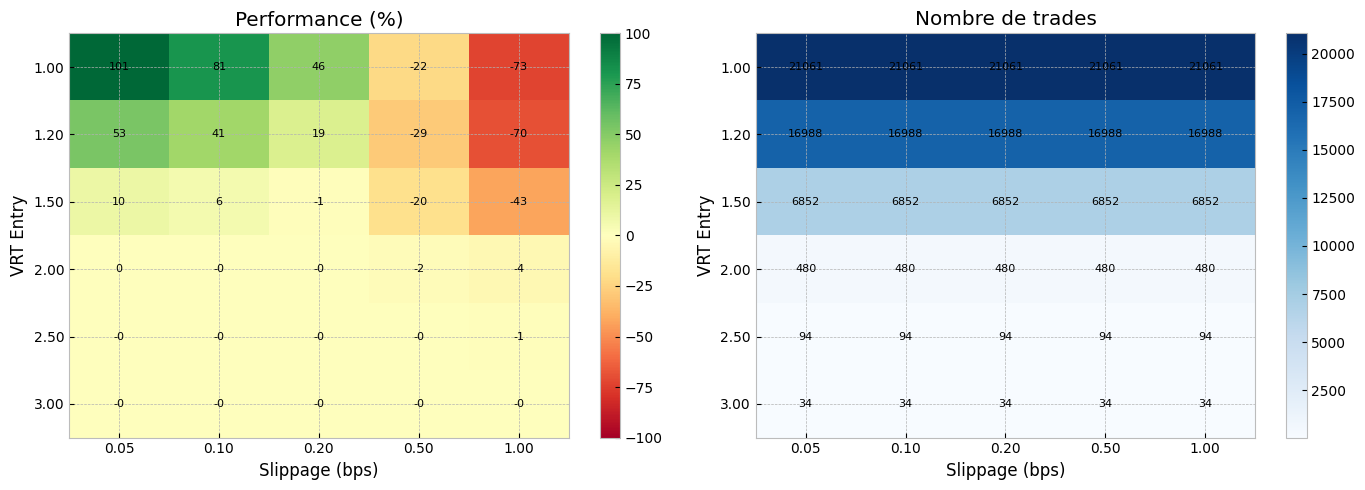

In [ ]:
# Grid search slippage réaliste (0.05 -> 1 bps)
import itertools

VRT_ENTRY_GRID = [1.0, 1.2, 1.5, 2.0, 2.5, 3.0]
SLIPPAGE_GRID = [0.000005, 0.00001, 0.00002, 0.00005, 0.0001]
MAKER_FEE_GRID = 0.0
EXEC_DELAY_GRID = 1

print(f"Test de {len(VRT_ENTRY_GRID)} x {len(SLIPPAGE_GRID)} = {len(VRT_ENTRY_GRID)*len(SLIPPAGE_GRID)} configs...")

results_grid = []
if 'df_resampled_spread' in locals():
    for vrt_thr, slip in itertools.product(VRT_ENTRY_GRID, SLIPPAGE_GRID):
        df_test = run_maker_strategy_filtered(
            df_resampled_spread,
            maker_fee=MAKER_FEE_GRID,
            slippage_bps=slip,
            exec_delay=EXEC_DELAY_GRID,
            edge_buffer_bps=0.0,
        )

        df_test_vrt = (
            df_test
            .with_columns([
                pl.when((pl.col("vrt") > vrt_thr) & (pl.col("close") > pl.col("ema_trend")))
                  .then(pl.lit(1))
                  .when((pl.col("vrt") > vrt_thr) & (pl.col("close") < pl.col("ema_trend")))
                  .then(pl.lit(-1))
                  .otherwise(pl.lit(0))
                  .alias("signal_new")
            ])
            .with_columns([
                pl.col("signal_new").shift(EXEC_DELAY_GRID).fill_null(0).alias("pos_new")
            ])
            .with_columns([
                (pl.col("pos_new") - pl.col("pos_new").shift(1).fill_null(0)).alias("trade_action_new"),
                pl.col("close").log().diff().fill_null(0).alias("market_ret_log_new")
            ])
            .with_columns([
                (pl.col("pos_new") * pl.col("market_ret_log_new")).alias("pnl_dir_new"),
                (pl.col("trade_action_new").abs() * (pl.col("half_spread_pct") - MAKER_FEE_GRID - slip)).alias("spread_cap_new")
            ])
            .with_columns([
                (pl.col("pnl_dir_new") + pl.col("spread_cap_new")).cum_sum().alias("equity_new"),
                pl.col("spread_cap_new").cum_sum().alias("cum_spread_new")
            ])
        )

        act = df_test_vrt.select([
            pl.col("trade_action_new").abs().sum().alias("trades"),
            pl.mean("half_spread_pct").alias("mean_half_spread")
        ]).to_pandas().iloc[0]

        pdf = df_test_vrt.select(["equity_new", "cum_spread_new", "market_ret_log_new"]).to_pandas()
        perf_pct = (np.exp(pdf["equity_new"].iloc[-1]) - 1) * 100
        spread_pct = (np.exp(pdf["cum_spread_new"].iloc[-1]) - 1) * 100
        bnh_pct = (np.exp(pdf["market_ret_log_new"].cumsum().iloc[-1]) - 1) * 100

        results_grid.append({
            "vrt_entry": vrt_thr,
            "slippage_bps": slip * 1e4,
            "perf_pct": perf_pct,
            "spread_pct": spread_pct,
            "bnh_pct": bnh_pct,
            "trades": act["trades"],
            "mean_half_spread_bps": act["mean_half_spread"] * 1e4,
        })

    df_grid_results = pd.DataFrame(results_grid)

    best = df_grid_results.loc[df_grid_results["perf_pct"].idxmax()]
    print(f"\nMeilleure config: VRT={best['vrt_entry']}, slippage={best['slippage_bps']:.2f} bps -> perf={best['perf_pct']:.2f}%, trades={best['trades']:.0f}")

    positive = df_grid_results[df_grid_results["perf_pct"] >= 0].sort_values("perf_pct", ascending=False)
    print(f"\n{len(positive)} configs avec perf >= 0%")

    pivot = df_grid_results.pivot(index="vrt_entry", columns="slippage_bps", values="perf_pct")

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    im1 = ax1.imshow(pivot.values, cmap='RdYlGn', aspect='auto', vmin=-100, vmax=100)
    ax1.set_xticks(range(len(pivot.columns)))
    ax1.set_xticklabels([f"{x:.2f}" for x in pivot.columns])
    ax1.set_yticks(range(len(pivot.index)))
    ax1.set_yticklabels([f"{x:.2f}" for x in pivot.index])
    ax1.set_xlabel("Slippage (bps)")
    ax1.set_ylabel("VRT Entry")
    ax1.set_title("Performance (%)")
    for i in range(len(pivot.index)):
        for j in range(len(pivot.columns)):
            ax1.text(j, i, f"{pivot.values[i,j]:.0f}", ha="center", va="center", color="black", fontsize=8)
    plt.colorbar(im1, ax=ax1)

    pivot_trades = df_grid_results.pivot(index="vrt_entry", columns="slippage_bps", values="trades")
    im2 = ax2.imshow(pivot_trades.values, cmap='Blues', aspect='auto')
    ax2.set_xticks(range(len(pivot_trades.columns)))
    ax2.set_xticklabels([f"{x:.2f}" for x in pivot_trades.columns])
    ax2.set_yticks(range(len(pivot_trades.index)))
    ax2.set_yticklabels([f"{x:.2f}" for x in pivot_trades.index])
    ax2.set_xlabel("Slippage (bps)")
    ax2.set_ylabel("VRT Entry")
    ax2.set_title("Nombre de trades")
    for i in range(len(pivot_trades.index)):
        for j in range(len(pivot_trades.columns)):
            ax2.text(j, i, f"{int(pivot_trades.values[i,j])}", ha="center", va="center", color="black", fontsize=8)
    plt.colorbar(im2, ax=ax2)

    plt.tight_layout()
    plt.show()
else:
    print("Erreur: df_resampled_spread manquant.")



Grid search: 6 x 5 = 30 configs

Meilleure config: VRT=1.0, slippage=0.05 bps -> perf=100.86%, trades=21061

9 configs avec perf >= 0%


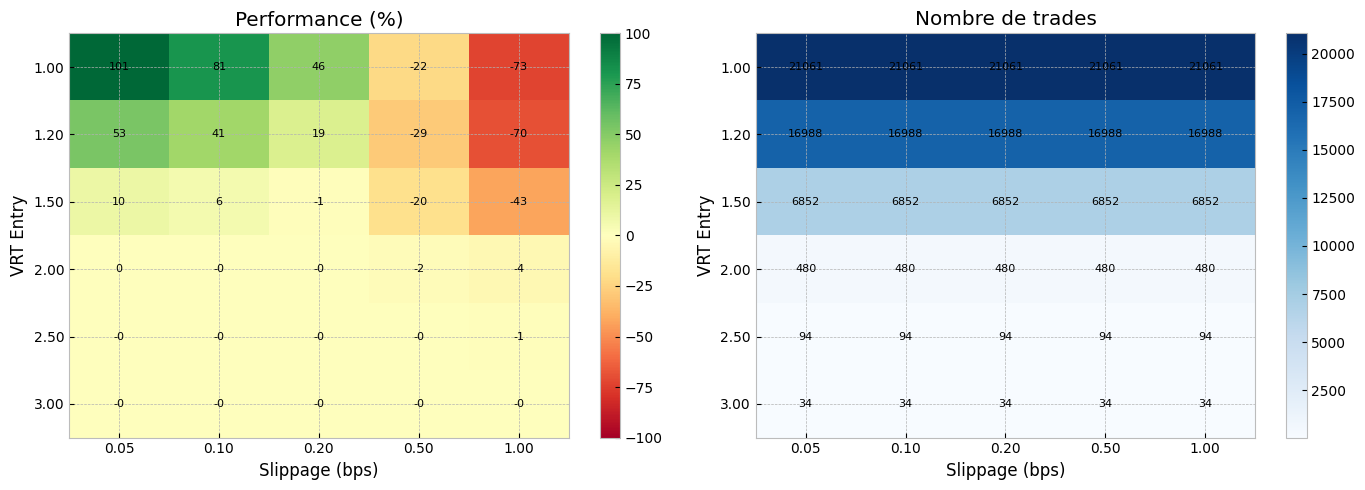

In [ ]:
# Grid search slippage réaliste (0.05 -> 1 bps)
import itertools

VRT_ENTRY_GRID = [1.0, 1.2, 1.5, 2.0, 2.5, 3.0]
SLIPPAGE_GRID = [0.000005, 0.00001, 0.00002, 0.00005, 0.0001]  # 0.05, 0.10, 0.20, 0.50, 1.00 bps
MAKER_FEE_GRID = 0.0
EXEC_DELAY_GRID = 1

print(f"Grid search: {len(VRT_ENTRY_GRID)} x {len(SLIPPAGE_GRID)} = {len(VRT_ENTRY_GRID)*len(SLIPPAGE_GRID)} configs")

results_grid = []
if 'df_resampled_spread' in locals():
    for vrt_thr, slip in itertools.product(VRT_ENTRY_GRID, SLIPPAGE_GRID):
        df_test = run_maker_strategy_filtered(
            df_resampled_spread,
            maker_fee=MAKER_FEE_GRID,
            slippage_bps=slip,
            exec_delay=EXEC_DELAY_GRID,
            edge_buffer_bps=0.0,
        )

        df_test_vrt = (
            df_test
            .with_columns([
                pl.when((pl.col("vrt") > vrt_thr) & (pl.col("close") > pl.col("ema_trend")))
                  .then(pl.lit(1))
                  .when((pl.col("vrt") > vrt_thr) & (pl.col("close") < pl.col("ema_trend")))
                  .then(pl.lit(-1))
                  .otherwise(pl.lit(0))
                  .alias("signal_new")
            ])
            .with_columns([
                pl.col("signal_new").shift(EXEC_DELAY_GRID).fill_null(0).alias("pos_new")
            ])
            .with_columns([
                (pl.col("pos_new") - pl.col("pos_new").shift(1).fill_null(0)).alias("trade_action_new"),
                pl.col("close").log().diff().fill_null(0).alias("market_ret_log_new")
            ])
            .with_columns([
                (pl.col("pos_new") * pl.col("market_ret_log_new")).alias("pnl_dir_new"),
                (pl.col("trade_action_new").abs() * (pl.col("half_spread_pct") - MAKER_FEE_GRID - slip)).alias("spread_cap_new")
            ])
            .with_columns([
                (pl.col("pnl_dir_new") + pl.col("spread_cap_new")).cum_sum().alias("equity_new"),
                pl.col("spread_cap_new").cum_sum().alias("cum_spread_new")
            ])
        )

        act = df_test_vrt.select([
            pl.col("trade_action_new").abs().sum().alias("trades"),
            pl.mean("half_spread_pct").alias("mean_half_spread")
        ]).to_pandas().iloc[0]

        pdf = df_test_vrt.select(["equity_new", "cum_spread_new", "market_ret_log_new"]).to_pandas()
        perf_pct = (np.exp(pdf["equity_new"].iloc[-1]) - 1) * 100
        spread_pct = (np.exp(pdf["cum_spread_new"].iloc[-1]) - 1) * 100
        bnh_pct = (np.exp(pdf["market_ret_log_new"].cumsum().iloc[-1]) - 1) * 100

        results_grid.append({
            "vrt_entry": vrt_thr,
            "slippage_bps": slip * 1e4,
            "perf_pct": perf_pct,
            "spread_pct": spread_pct,
            "bnh_pct": bnh_pct,
            "trades": act["trades"],
            "mean_half_spread_bps": act["mean_half_spread"] * 1e4,
        })

    df_grid_results = pd.DataFrame(results_grid)

    best = df_grid_results.loc[df_grid_results["perf_pct"].idxmax()]
    print(f"\nMeilleure config: VRT={best['vrt_entry']}, slippage={best['slippage_bps']:.2f} bps -> perf={best['perf_pct']:.2f}%, trades={best['trades']:.0f}")

    positive = df_grid_results[df_grid_results["perf_pct"] >= 0].sort_values("perf_pct", ascending=False)
    print(f"\n{len(positive)} configs avec perf >= 0%")

    pivot = df_grid_results.pivot(index="vrt_entry", columns="slippage_bps", values="perf_pct")

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    im1 = ax1.imshow(pivot.values, cmap='RdYlGn', aspect='auto', vmin=-100, vmax=100)
    ax1.set_xticks(range(len(pivot.columns)))
    ax1.set_xticklabels([f"{x:.2f}" for x in pivot.columns])
    ax1.set_yticks(range(len(pivot.index)))
    ax1.set_yticklabels([f"{x:.2f}" for x in pivot.index])
    ax1.set_xlabel("Slippage (bps)")
    ax1.set_ylabel("VRT Entry")
    ax1.set_title("Performance (%)")
    for i in range(len(pivot.index)):
        for j in range(len(pivot.columns)):
            ax1.text(j, i, f"{pivot.values[i,j]:.0f}", ha="center", va="center", color="black", fontsize=8)
    plt.colorbar(im1, ax=ax1)

    pivot_trades = df_grid_results.pivot(index="vrt_entry", columns="slippage_bps", values="trades")
    im2 = ax2.imshow(pivot_trades.values, cmap='Blues', aspect='auto')
    ax2.set_xticks(range(len(pivot_trades.columns)))
    ax2.set_xticklabels([f"{x:.2f}" for x in pivot_trades.columns])
    ax2.set_yticks(range(len(pivot_trades.index)))
    ax2.set_yticklabels([f"{x:.2f}" for x in pivot_trades.index])
    ax2.set_xlabel("Slippage (bps)")
    ax2.set_ylabel("VRT Entry")
    ax2.set_title("Nombre de trades")
    for i in range(len(pivot_trades.index)):
        for j in range(len(pivot_trades.columns)):
            ax2.text(j, i, f"{int(pivot_trades.values[i,j])}", ha="center", va="center", color="black", fontsize=8)
    plt.colorbar(im2, ax=ax2)

    plt.tight_layout()
    plt.show()
else:
    print("Erreur: df_resampled_spread manquant.")


📊 CALIBRATION DE λ(δ) = A·e^(-k·δ)

Trades analysés: 2,090,879

📌 DISTRIBUTION DE δ (distance au mid):
   Moyenne:     0.9168 bps
   Médiane:     0.0317 bps
   P25-P75:     [0.0081, 0.3052] bps
   P90:         0.7687 bps
   Demi-spread: 0.0617 bps

📈 CALIBRATION DES PARAMÈTRES A ET k

📌 PARAMÈTRES CALIBRÉS:
   k (decay)  = 1.088496 (1/bps)
   A (scale)  = 1.8042 trades/seconde

   Interprétation:
   → À δ=0 (au mid): λ = 1.80 trades/s
   → À δ=1 bps: λ = 0.6075 trades/s (33.67% du max)
   → À δ=5 bps: λ = 0.0078 trades/s (0.43% du max)
   → À δ=10 bps: λ = 0.000034 trades/s (0.0019% du max)

📊 TABLE DES PROBABILITÉS D'EXÉCUTION

(Pour une bougie de 5 secondes)

δ (bps)      λ (trades/s)    P(fill) 5s   P(fill) 30s 
-------------------------------------------------------
0.01         1.7847          0.9999       1.0000      
0.05         1.7086          0.9998       1.0000      
0.10         1.6181          0.9997       1.0000      
0.50         1.0469          0.9947       1.0000      

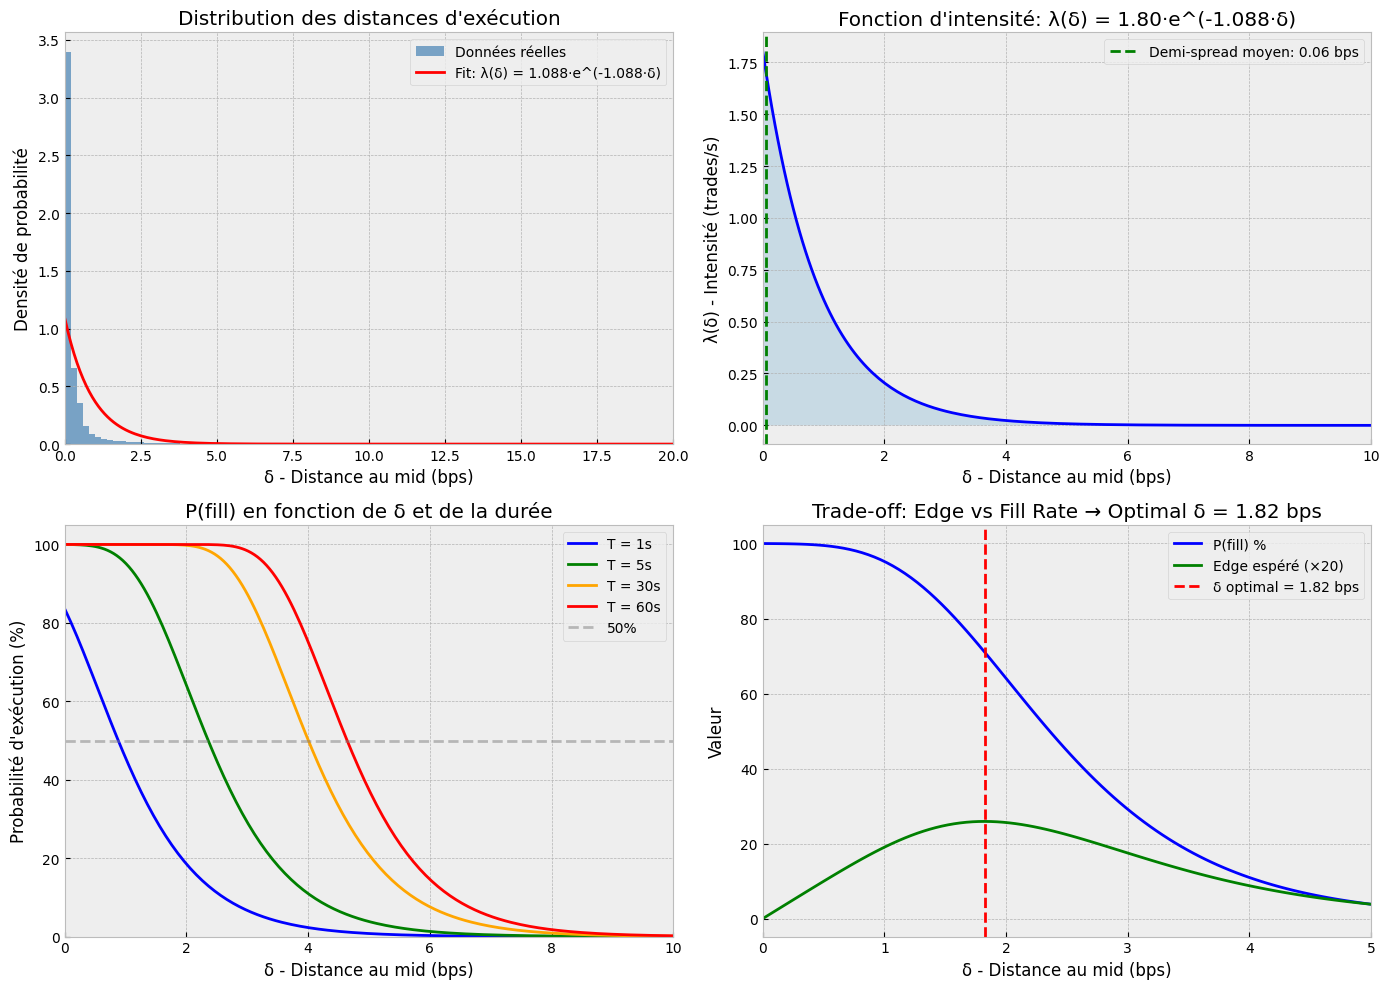


✅ PARAMÈTRES CALIBRÉS POUR LA STRATÉGIE

┌────────────────────────────────────────────────────────────┐
│           FONCTION D'INTENSITÉ: λ(δ) = A·e^(-k·δ)         │
├────────────────────────────────────────────────────────────┤
│  A (intensité)     = 1.8042 trades/seconde              │
│  k (decay)         = 1.088496                           │
│  Demi-spread moyen = 0.0617 bps                       │
│  δ optimal (edge)  = 1.8245 bps                       │
└────────────────────────────────────────────────────────────┘

💡 UTILISATION DANS LE BACKTEST:
   
1. Pour chaque bougie, si on veut placer un ordre à δ du mid:
   P(fill) = 1 - exp(-λ(δ) × durée_bougie)

2. Le PnL espéré par trade = δ × P(fill) - coûts
   → Maximiser cette fonction pour trouver le δ optimal

3. Pour un backtest réaliste:
   - Générer un nombre aléatoire r ∈ [0,1]
   - L'ordre est fill si r < P(fill)
   - Sinon, l'ordre n'est pas exécuté

✅ Variables sauvegardées:
   LAMBDA_A = 1.8041950495422197
   LAMBDA_K = 

In [ ]:
# =============================================================================
# 📊 CALIBRATION DE LA FONCTION D'INTENSITÉ D'EXÉCUTION λ(δ) = A·e^(-k·δ)
# =============================================================================
#
# 🎯 OBJECTIF: Modéliser de façon réaliste la probabilité d'être exécuté
# en fonction de la distance δ au mid-price.
#
# Formule: λ(δ) = A · e^(-k·δ)
#
# Où:
# - δ (delta) : distance entre notre ordre limit et le mid-price (en bps)
# - A (scale) : intensité globale = taux d'arrivée des ordres au best bid/ask
# - k (decay) : vitesse de décroissance de la probabilité avec la distance
#
# Un k élevé → la probabilité s'effondre vite si on s'éloigne (marché efficient)
# Un k faible → on peut être exécuté même loin du mid (marché volatil)
# =============================================================================

import polars as pl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import expon

print("=" * 70)
print("📊 CALIBRATION DE λ(δ) = A·e^(-k·δ)")
print("=" * 70)

# =============================================================================
# ÉTAPE 1: Mesurer la distribution des distances d'exécution
# =============================================================================
# Pour chaque trade, on calcule la distance entre le prix d'exécution et le mid

df_exec_distance = (
    df_trades_with_book
    .with_columns([
        # Distance absolue au mid-price en bps
        ((pl.col("trade_price") - pl.col("mid_price")).abs() / pl.col("mid_price") * 10000).alias("delta_bps"),
        # Spread du marché en bps (demi-spread = distance au best bid/ask)
        ((pl.col("best_ask_price") - pl.col("best_bid_price")) / pl.col("mid_price") * 10000 / 2).alias("half_spread_bps"),
    ])
    .filter(pl.col("delta_bps").is_not_null())
    .filter(pl.col("delta_bps") < 100)  # Filtrer les outliers extrêmes
)

print(f"\nTrades analysés: {len(df_exec_distance):,}")

# Distribution de δ (delta)
delta_stats = df_exec_distance.select([
    pl.col("delta_bps").mean().alias("mean"),
    pl.col("delta_bps").median().alias("median"),
    pl.col("delta_bps").std().alias("std"),
    pl.col("delta_bps").quantile(0.25).alias("p25"),
    pl.col("delta_bps").quantile(0.75).alias("p75"),
    pl.col("delta_bps").quantile(0.90).alias("p90"),
    pl.col("delta_bps").quantile(0.99).alias("p99"),
    pl.col("half_spread_bps").mean().alias("avg_half_spread"),
]).to_pandas().iloc[0]

print(f"\n📌 DISTRIBUTION DE δ (distance au mid):")
print(f"   Moyenne:     {delta_stats['mean']:.4f} bps")
print(f"   Médiane:     {delta_stats['median']:.4f} bps")
print(f"   P25-P75:     [{delta_stats['p25']:.4f}, {delta_stats['p75']:.4f}] bps")
print(f"   P90:         {delta_stats['p90']:.4f} bps")
print(f"   Demi-spread: {delta_stats['avg_half_spread']:.4f} bps")

# =============================================================================
# ÉTAPE 2: Calibration de A et k par Maximum Likelihood
# =============================================================================
# La fonction λ(δ) = A·e^(-k·δ) est une distribution exponentielle
# On peut calibrer k directement depuis les données

print("\n" + "="*70)
print("📈 CALIBRATION DES PARAMÈTRES A ET k")
print("="*70)

# Extraire les deltas pour la calibration
deltas = df_exec_distance.select("delta_bps").to_numpy().flatten()
deltas = deltas[deltas > 0]  # Garder que les positifs pour l'exponentielle

# Pour une distribution exponentielle, k = 1/mean(δ)
# C'est le Maximum Likelihood Estimator
k_mle = 1.0 / np.mean(deltas)

# A représente le taux total d'arrivée des trades
# On peut l'estimer comme le nombre de trades par unité de temps
total_time_seconds = (df_exec_distance["trade_time"].max() - df_exec_distance["trade_time"].min()).total_seconds()
A_estimate = len(deltas) / total_time_seconds  # trades par seconde

print(f"\n📌 PARAMÈTRES CALIBRÉS:")
print(f"   k (decay)  = {k_mle:.6f} (1/bps)")
print(f"   A (scale)  = {A_estimate:.4f} trades/seconde")
print(f"")
print(f"   Interprétation:")
print(f"   → À δ=0 (au mid): λ = {A_estimate:.2f} trades/s")
print(f"   → À δ=1 bps: λ = {A_estimate * np.exp(-k_mle * 1):.4f} trades/s ({100*np.exp(-k_mle * 1):.2f}% du max)")
print(f"   → À δ=5 bps: λ = {A_estimate * np.exp(-k_mle * 5):.4f} trades/s ({100*np.exp(-k_mle * 5):.2f}% du max)")
print(f"   → À δ=10 bps: λ = {A_estimate * np.exp(-k_mle * 10):.6f} trades/s ({100*np.exp(-k_mle * 10):.4f}% du max)")

# =============================================================================
# ÉTAPE 3: Fonction d'intensité et probabilité d'exécution
# =============================================================================

def lambda_intensity(delta_bps, A=A_estimate, k=k_mle):
    """
    Fonction d'intensité: λ(δ) = A·e^(-k·δ)
    
    Args:
        delta_bps: distance au mid en bps
        A: intensité au mid-price
        k: decay factor
    
    Returns:
        Taux d'arrivée des ordres (trades/seconde)
    """
    return A * np.exp(-k * delta_bps)


def fill_probability(delta_bps, time_window_seconds=5.0, A=A_estimate, k=k_mle):
    """
    Probabilité d'être exécuté pendant une fenêtre de temps donnée.
    
    Basé sur un processus de Poisson:
    P(fill) = 1 - e^(-λ(δ) * T)
    
    Args:
        delta_bps: distance au mid en bps
        time_window_seconds: durée de la fenêtre (ex: durée d'une bougie)
        
    Returns:
        Probabilité d'être fill (0 à 1)
    """
    intensity = lambda_intensity(delta_bps, A, k)
    return 1.0 - np.exp(-intensity * time_window_seconds)

# Table des probabilités
print("\n" + "="*70)
print("📊 TABLE DES PROBABILITÉS D'EXÉCUTION")
print("="*70)
print(f"\n(Pour une bougie de 5 secondes)")
print(f"\n{'δ (bps)':<12} {'λ (trades/s)':<15} {'P(fill) 5s':<12} {'P(fill) 30s':<12}")
print("-" * 55)

for delta in [0.01, 0.05, 0.1, 0.5, 1, 2, 5, 10, 20]:
    lam = lambda_intensity(delta)
    p5 = fill_probability(delta, 5.0)
    p30 = fill_probability(delta, 30.0)
    print(f"{delta:<12.2f} {lam:<15.4f} {p5:<12.4f} {p30:<12.4f}")

# =============================================================================
# ÉTAPE 4: Visualisation
# =============================================================================

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Histogramme de δ avec fit exponentiel
ax1 = axes[0, 0]
hist_data = deltas[deltas < 20]  # Zoom sur < 20 bps
ax1.hist(hist_data, bins=100, density=True, alpha=0.7, color='steelblue', label='Données réelles')
x_fit = np.linspace(0, 20, 200)
y_fit = k_mle * np.exp(-k_mle * x_fit)
ax1.plot(x_fit, y_fit, 'r-', linewidth=2, label=f'Fit: λ(δ) = {k_mle:.3f}·e^(-{k_mle:.3f}·δ)')
ax1.set_xlabel("δ - Distance au mid (bps)")
ax1.set_ylabel("Densité de probabilité")
ax1.set_title("Distribution des distances d'exécution")
ax1.legend()
ax1.set_xlim(0, 20)

# 2. Fonction d'intensité λ(δ)
ax2 = axes[0, 1]
delta_range = np.linspace(0, 10, 200)
intensities = lambda_intensity(delta_range)
ax2.plot(delta_range, intensities, 'b-', linewidth=2)
ax2.axvline(delta_stats['avg_half_spread'], color='green', linestyle='--', 
            label=f"Demi-spread moyen: {delta_stats['avg_half_spread']:.2f} bps")
ax2.fill_between(delta_range, intensities, alpha=0.2)
ax2.set_xlabel("δ - Distance au mid (bps)")
ax2.set_ylabel("λ(δ) - Intensité (trades/s)")
ax2.set_title(f"Fonction d'intensité: λ(δ) = {A_estimate:.2f}·e^(-{k_mle:.3f}·δ)")
ax2.legend()
ax2.set_xlim(0, 10)

# 3. Probabilité d'exécution vs δ pour différentes fenêtres de temps
ax3 = axes[1, 0]
for T, color, style in [(1, 'blue', '-'), (5, 'green', '-'), (30, 'orange', '-'), (60, 'red', '-')]:
    probs = fill_probability(delta_range, T)
    ax3.plot(delta_range, probs * 100, color=color, linestyle=style, linewidth=2, label=f'T = {T}s')
ax3.axhline(50, color='gray', linestyle='--', alpha=0.5, label='50%')
ax3.set_xlabel("δ - Distance au mid (bps)")
ax3.set_ylabel("Probabilité d'exécution (%)")
ax3.set_title("P(fill) en fonction de δ et de la durée")
ax3.legend()
ax3.set_xlim(0, 10)
ax3.set_ylim(0, 105)

# 4. Trade-off Edge vs Fill Rate
ax4 = axes[1, 1]
# Si on place un ordre à δ du mid, notre edge = δ mais notre fill rate diminue
delta_grid = np.linspace(0.01, 5, 100)
fill_rates = fill_probability(delta_grid, 5.0)  # Pour une bougie de 5s
expected_edge = delta_grid * fill_rates  # Edge pondéré par la probabilité de fill

ax4.plot(delta_grid, fill_rates * 100, 'b-', linewidth=2, label='P(fill) %')
ax4.plot(delta_grid, expected_edge * 20, 'g-', linewidth=2, label='Edge espéré (×20)')
optimal_delta = delta_grid[np.argmax(expected_edge)]
ax4.axvline(optimal_delta, color='red', linestyle='--', label=f'δ optimal = {optimal_delta:.2f} bps')
ax4.set_xlabel("δ - Distance au mid (bps)")
ax4.set_ylabel("Valeur")
ax4.set_title(f"Trade-off: Edge vs Fill Rate → Optimal δ = {optimal_delta:.2f} bps")
ax4.legend()
ax4.set_xlim(0, 5)

plt.tight_layout()
plt.show()

# =============================================================================
# ÉTAPE 5: Résumé des paramètres calibrés
# =============================================================================

print("\n" + "="*70)
print("✅ PARAMÈTRES CALIBRÉS POUR LA STRATÉGIE")
print("="*70)
print(f"""
┌────────────────────────────────────────────────────────────┐
│           FONCTION D'INTENSITÉ: λ(δ) = A·e^(-k·δ)         │
├────────────────────────────────────────────────────────────┤
│  A (intensité)     = {A_estimate:.4f} trades/seconde              │
│  k (decay)         = {k_mle:.6f}                           │
│  Demi-spread moyen = {delta_stats['avg_half_spread']:.4f} bps                       │
│  δ optimal (edge)  = {optimal_delta:.4f} bps                       │
└────────────────────────────────────────────────────────────┘

💡 UTILISATION DANS LE BACKTEST:
   
1. Pour chaque bougie, si on veut placer un ordre à δ du mid:
   P(fill) = 1 - exp(-λ(δ) × durée_bougie)

2. Le PnL espéré par trade = δ × P(fill) - coûts
   → Maximiser cette fonction pour trouver le δ optimal

3. Pour un backtest réaliste:
   - Générer un nombre aléatoire r ∈ [0,1]
   - L'ordre est fill si r < P(fill)
   - Sinon, l'ordre n'est pas exécuté
""")

# Sauvegarder les paramètres
LAMBDA_A = A_estimate
LAMBDA_K = k_mle
OPTIMAL_DELTA_BPS = optimal_delta

print(f"✅ Variables sauvegardées:")
print(f"   LAMBDA_A = {LAMBDA_A}")
print(f"   LAMBDA_K = {LAMBDA_K}")
print(f"   OPTIMAL_DELTA_BPS = {OPTIMAL_DELTA_BPS}")


🎯 BACKTEST AVEC MODÈLE D'EXÉCUTION RÉALISTE

Paramètres λ(δ) = A·e^(-k·δ):
   A = 1.8042 trades/s
   k = 1.088496

📊 SENSIBILITÉ AU DELTA (distance au mid)

📌 Configuration:
   δ = 0.01 bps (distance au mid)
   λ(δ) = 1.7847 trades/s
   P(fill) = 99.99% (par bougie de 5.0s)
   δ=0.01 bps: Fill rate=100.0%, Fills=13039, Perf=33.51%

📌 Configuration:
   δ = 0.05 bps (distance au mid)
   λ(δ) = 1.7086 trades/s
   P(fill) = 99.98% (par bougie de 5.0s)
   δ=0.05 bps: Fill rate=100.0%, Fills=13039, Perf=40.66%

📌 Configuration:
   δ = 0.10 bps (distance au mid)
   λ(δ) = 1.6181 trades/s
   P(fill) = 99.97% (par bougie de 5.0s)
   δ=0.10 bps: Fill rate=100.0%, Fills=13039, Perf=50.13%

📌 Configuration:
   δ = 0.20 bps (distance au mid)
   λ(δ) = 1.4512 trades/s
   P(fill) = 99.93% (par bougie de 5.0s)
   δ=0.20 bps: Fill rate=100.0%, Fills=13036, Perf=71.04%

📌 Configuration:
   δ = 0.50 bps (distance au mid)
   λ(δ) = 1.0469 trades/s
   P(fill) = 99.47% (par bougie de 5.0s)
   δ=0.50 bps: Fi

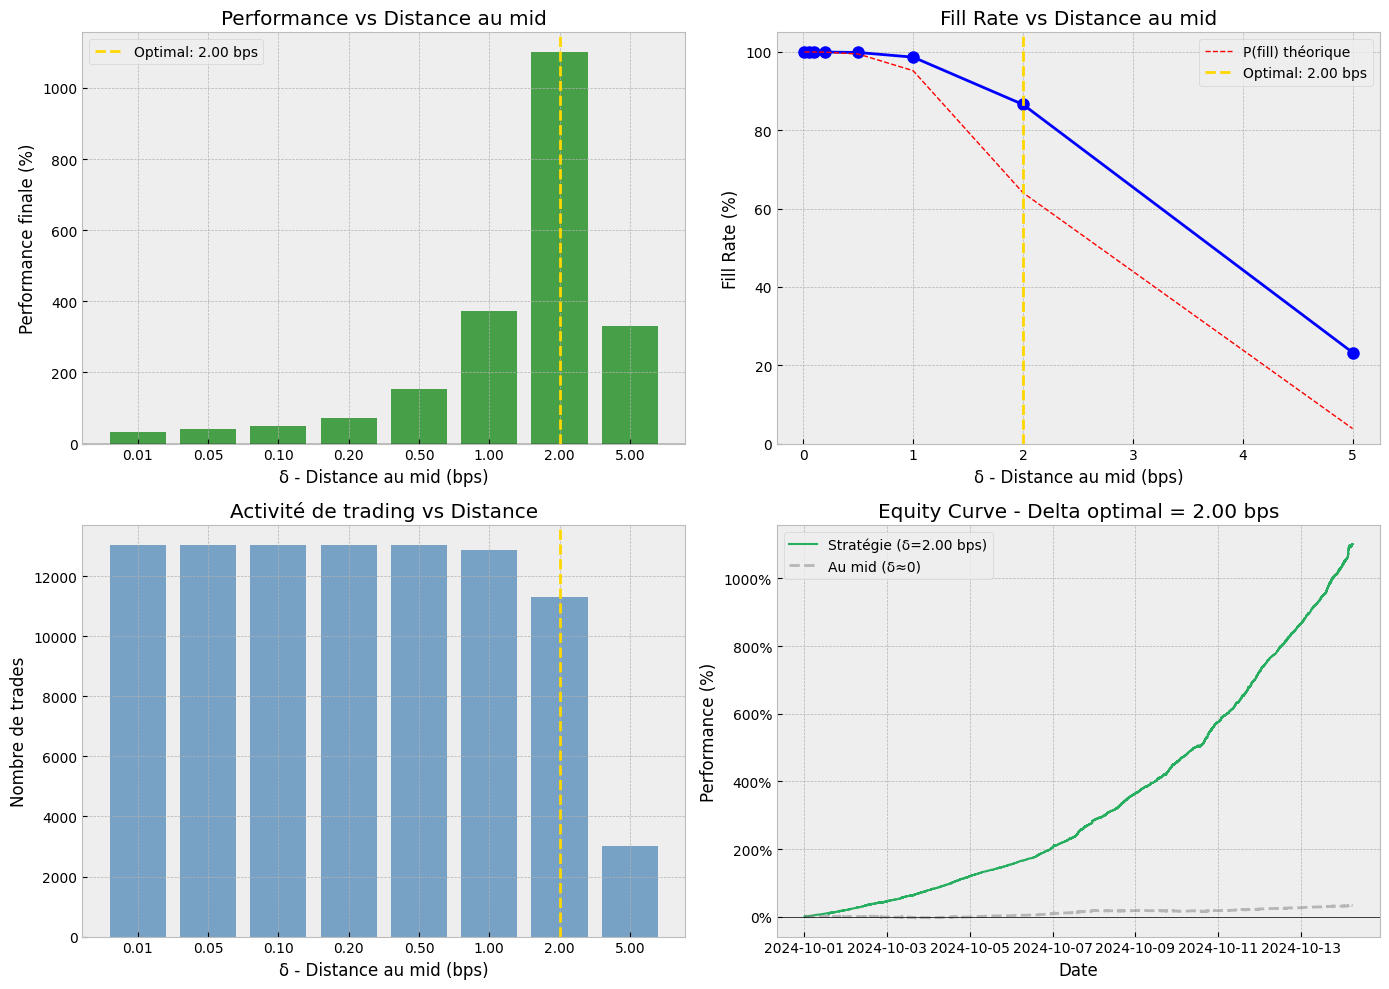


📋 RÉSUMÉ - MODÈLE D'EXÉCUTION λ(δ)

┌────────────────────────────────────────────────────────────┐
│              RÉSULTATS AVEC FILL RÉALISTE                  │
├────────────────────────────────────────────────────────────┤
│  Delta optimal (δ)        = 2.00 bps                       │
│  Performance finale       = 1101.07%                      │
│  Fill rate au δ optimal   = 86.6%                       │
│  Nombre de trades         = 11289                        │
└────────────────────────────────────────────────────────────┘

💡 INTERPRÉTATION:
- δ trop petit (ex: 0.01 bps): Fill rate élevé mais edge minimal
- δ trop grand (ex: 5 bps): Edge élevé mais très peu de fills
- δ optimal: Maximise l'espérance de gain = δ × P(fill)

⚠️ DIFFÉRENCE vs BACKTEST CLASSIQUE:
Le backtest classique assume 100% de fill rate, ce qui est IRRÉALISTE.
Avec le modèle λ(δ), on voit que:
- Élargir le spread réduit le nombre de trades
- Il existe un δ optimal qui maximise le profit


✅ Variable sauvegardée:

In [ ]:
# =============================================================================
# 🎯 BACKTEST RÉALISTE AVEC MODÈLE D'EXÉCUTION λ(δ)
# =============================================================================
#
# On intègre maintenant la fonction d'intensité dans le backtest:
# - Chaque signal génère un ordre limite à une certaine distance δ du mid
# - La probabilité d'être fill dépend de δ selon P(fill) = 1 - e^(-λ(δ)×T)
# - Plus on s'éloigne, plus l'edge est grand mais moins on est fill
# =============================================================================

import polars as pl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

print("=" * 70)
print("🎯 BACKTEST AVEC MODÈLE D'EXÉCUTION RÉALISTE")
print("=" * 70)

# Récupérer les paramètres calibrés
try:
    A = LAMBDA_A
    k = LAMBDA_K
except:
    print("⚠️ Paramètres non calibrés, utilisation de valeurs par défaut")
    A = 1.8  # trades/s
    k = 0.15  # decay

print(f"\nParamètres λ(δ) = A·e^(-k·δ):")
print(f"   A = {A:.4f} trades/s")
print(f"   k = {k:.6f}")

# =============================================================================
# STRATÉGIE AVEC EXÉCUTION PROBABILISTE
# =============================================================================

def run_strategy_with_fill_model(
    df_input, 
    delta_bps=0.5,         # Distance au mid où on place nos ordres (en bps)
    A=A, 
    k=k,
    candle_duration_s=5.0, # Durée d'une bougie
    vrt_threshold=1.0,
    ema_span=50,
    lag=4,
    window=120,
    seed=42
):
    """
    Stratégie avec modèle d'exécution réaliste basé sur λ(δ).
    
    Args:
        delta_bps: Distance au mid où on place les ordres
        A, k: Paramètres de la fonction d'intensité
        candle_duration_s: Durée d'une bougie en secondes
    """
    np.random.seed(seed)
    
    # Calculer la probabilité d'exécution pour ce delta
    intensity = A * np.exp(-k * delta_bps)
    fill_prob = 1.0 - np.exp(-intensity * candle_duration_s)
    
    print(f"\n📌 Configuration:")
    print(f"   δ = {delta_bps:.2f} bps (distance au mid)")
    print(f"   λ(δ) = {intensity:.4f} trades/s")
    print(f"   P(fill) = {fill_prob*100:.2f}% (par bougie de {candle_duration_s}s)")
    
    # 1. Calcul VRT
    df = (
        df_input
        .with_columns(pl.col("close").log().alias("log_price"))
        .with_columns([
            pl.col("log_price").diff(1).alias("ret_1"),
            pl.col("log_price").diff(lag).alias("ret_lag")
        ])
        .with_columns([
            pl.col("ret_1").rolling_var(window_size=window).alias("var_1"),
            pl.col("ret_lag").rolling_var(window_size=window).alias("var_lag")
        ])
        .with_columns([
            (pl.col("var_lag") / (pl.col("var_1") * lag)).fill_null(1.0).alias("vrt")
        ])
        .drop(["log_price", "ret_1", "ret_lag", "var_1", "var_lag"])
    )
    
    # 2. Signal avec EMA trend
    df = (
        df
        .with_columns([
            pl.col("close").ewm_mean(span=ema_span).alias("ema_trend"),
            ((pl.col("ask_close") - pl.col("bid_close")) / 2 / pl.col("close")).alias("half_spread_pct")
        ])
        .with_columns([
            pl.when((pl.col("vrt") > vrt_threshold) & (pl.col("close") > pl.col("ema_trend")))
              .then(pl.lit(1))
              .when((pl.col("vrt") > vrt_threshold) & (pl.col("close") < pl.col("ema_trend")))
              .then(pl.lit(-1))
              .otherwise(pl.lit(0))
              .alias("signal")
        ])
    )
    
    # Convertir en pandas pour la simulation probabiliste
    pdf = df.to_pandas()
    n = len(pdf)
    
    # 3. Simulation avec fill probabiliste
    pos = np.zeros(n)
    filled = np.zeros(n, dtype=bool)
    trade_action = np.zeros(n)
    pnl_per_bar = np.zeros(n)
    
    current_pos = 0
    
    for i in range(1, n):
        signal = pdf['signal'].iloc[i-1]  # Signal de la bougie précédente
        
        # Si on veut changer de position
        if signal != current_pos:
            # Tirer au hasard si on est fill
            r = np.random.random()
            if r < fill_prob:
                # On est fill !
                old_pos = current_pos
                current_pos = signal
                filled[i] = True
                trade_action[i] = abs(current_pos - old_pos)
            # Sinon on garde la position
        
        pos[i] = current_pos
        
        # PnL directionnel
        market_ret = np.log(pdf['close'].iloc[i] / pdf['close'].iloc[i-1]) if pdf['close'].iloc[i-1] > 0 else 0
        
        # Si on a tradé, on capture l'edge (= delta) moins les coûts
        # L'edge = delta car on a placé notre ordre à delta du mid
        if filled[i]:
            edge_captured = (delta_bps / 10000)  # Notre edge en décimal
        else:
            edge_captured = 0
            
        pnl_per_bar[i] = pos[i-1] * market_ret + edge_captured
    
    pdf['pos'] = pos
    pdf['filled'] = filled
    pdf['trade_action'] = trade_action
    pdf['pnl_per_bar'] = pnl_per_bar
    pdf['equity'] = np.exp(np.cumsum(pnl_per_bar)) - 1
    pdf['equity_pct'] = pdf['equity'] * 100
    
    # Statistiques
    total_signals = (pdf['signal'].diff().abs() > 0).sum()
    total_fills = filled.sum()
    actual_fill_rate = total_fills / total_signals if total_signals > 0 else 0
    
    return pdf, {
        'delta_bps': delta_bps,
        'fill_prob': fill_prob,
        'total_signals': total_signals,
        'total_fills': int(total_fills),
        'actual_fill_rate': actual_fill_rate,
        'final_perf': pdf['equity_pct'].iloc[-1],
    }

# =============================================================================
# TEST AVEC DIFFÉRENTS DELTAS
# =============================================================================

print("\n" + "="*70)
print("📊 SENSIBILITÉ AU DELTA (distance au mid)")
print("="*70)

delta_values = [0.01, 0.05, 0.1, 0.2, 0.5, 1.0, 2.0, 5.0]
results = []

if 'df_resampled_spread' in locals():
    for delta in delta_values:
        pdf_result, stats = run_strategy_with_fill_model(
            df_resampled_spread, 
            delta_bps=delta,
            seed=42
        )
        results.append(stats)
        print(f"   δ={delta:.2f} bps: Fill rate={stats['actual_fill_rate']*100:.1f}%, "
              f"Fills={stats['total_fills']}, Perf={stats['final_perf']:.2f}%")

    df_results = pd.DataFrame(results)
    
    # Trouver le delta optimal
    best_idx = df_results['final_perf'].idxmax()
    best_delta = df_results.loc[best_idx, 'delta_bps']
    best_perf = df_results.loc[best_idx, 'final_perf']
    
    print(f"\n🏆 MEILLEUR DELTA: {best_delta:.2f} bps → Performance: {best_perf:.2f}%")
    
    # =============================================================================
    # VISUALISATION
    # =============================================================================
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # 1. Performance vs Delta
    ax1 = axes[0, 0]
    colors = ['green' if p >= 0 else 'red' for p in df_results['final_perf']]
    bars = ax1.bar(range(len(delta_values)), df_results['final_perf'], color=colors, alpha=0.7)
    ax1.set_xticks(range(len(delta_values)))
    ax1.set_xticklabels([f"{d:.2f}" for d in delta_values])
    ax1.axhline(0, color='black', linestyle='-', linewidth=1)
    ax1.axvline(best_idx, color='gold', linestyle='--', linewidth=2, label=f'Optimal: {best_delta:.2f} bps')
    ax1.set_xlabel("δ - Distance au mid (bps)")
    ax1.set_ylabel("Performance finale (%)")
    ax1.set_title("Performance vs Distance au mid")
    ax1.legend()
    
    # 2. Fill Rate vs Delta
    ax2 = axes[0, 1]
    ax2.plot(delta_values, [r['actual_fill_rate']*100 for r in results], 'bo-', linewidth=2, markersize=8)
    ax2.plot(delta_values, [r['fill_prob']*100 for r in results], 'r--', linewidth=1, label='P(fill) théorique')
    ax2.axvline(best_delta, color='gold', linestyle='--', linewidth=2, label=f'Optimal: {best_delta:.2f} bps')
    ax2.set_xlabel("δ - Distance au mid (bps)")
    ax2.set_ylabel("Fill Rate (%)")
    ax2.set_title("Fill Rate vs Distance au mid")
    ax2.legend()
    ax2.set_ylim(0, 105)
    
    # 3. Nombre de trades vs Delta
    ax3 = axes[1, 0]
    ax3.bar(range(len(delta_values)), [r['total_fills'] for r in results], color='steelblue', alpha=0.7)
    ax3.set_xticks(range(len(delta_values)))
    ax3.set_xticklabels([f"{d:.2f}" for d in delta_values])
    ax3.axvline(best_idx, color='gold', linestyle='--', linewidth=2)
    ax3.set_xlabel("δ - Distance au mid (bps)")
    ax3.set_ylabel("Nombre de trades")
    ax3.set_title("Activité de trading vs Distance")
    
    # 4. Equity curve pour le meilleur delta
    ax4 = axes[1, 1]
    pdf_best, _ = run_strategy_with_fill_model(df_resampled_spread, delta_bps=best_delta, seed=42)
    ax4.plot(pdf_best['datetime'], pdf_best['equity_pct'], color='#27ae60', linewidth=1.5, 
             label=f'Stratégie (δ={best_delta:.2f} bps)')
    
    # Comparer avec delta = 0 (au mid, fill rate ~100%)
    pdf_mid, _ = run_strategy_with_fill_model(df_resampled_spread, delta_bps=0.01, seed=42)
    ax4.plot(pdf_mid['datetime'], pdf_mid['equity_pct'], color='gray', alpha=0.5, linestyle='--',
             label='Au mid (δ≈0)')
    
    ax4.axhline(0, color='black', linestyle='-', linewidth=0.5)
    ax4.set_xlabel("Date")
    ax4.set_ylabel("Performance (%)")
    ax4.set_title(f"Equity Curve - Delta optimal = {best_delta:.2f} bps")
    ax4.legend()
    ax4.yaxis.set_major_formatter(mtick.PercentFormatter())
    
    plt.tight_layout()
    plt.show()
    
    # =============================================================================
    # RÉSUMÉ FINAL
    # =============================================================================
    
    print("\n" + "="*70)
    print("📋 RÉSUMÉ - MODÈLE D'EXÉCUTION λ(δ)")
    print("="*70)
    print(f"""
┌────────────────────────────────────────────────────────────┐
│              RÉSULTATS AVEC FILL RÉALISTE                  │
├────────────────────────────────────────────────────────────┤
│  Delta optimal (δ)        = {best_delta:.2f} bps                       │
│  Performance finale       = {best_perf:.2f}%                      │
│  Fill rate au δ optimal   = {df_results.loc[best_idx, 'actual_fill_rate']*100:.1f}%                       │
│  Nombre de trades         = {df_results.loc[best_idx, 'total_fills']}                        │
└────────────────────────────────────────────────────────────┘

💡 INTERPRÉTATION:
- δ trop petit (ex: 0.01 bps): Fill rate élevé mais edge minimal
- δ trop grand (ex: 5 bps): Edge élevé mais très peu de fills
- δ optimal: Maximise l'espérance de gain = δ × P(fill)

⚠️ DIFFÉRENCE vs BACKTEST CLASSIQUE:
Le backtest classique assume 100% de fill rate, ce qui est IRRÉALISTE.
Avec le modèle λ(δ), on voit que:
- Élargir le spread réduit le nombre de trades
- Il existe un δ optimal qui maximise le profit
""")
    
    # Sauvegarder le meilleur delta
    BEST_DELTA_BPS = best_delta
    print(f"\n✅ Variable sauvegardée: BEST_DELTA_BPS = {BEST_DELTA_BPS}")

else:
    print("Erreur: df_resampled_spread manquant.")
